# Deepdive notebook converted to plot proper figures

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from numpy import core
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from functions import *
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


Color consistency
Reward and contour and dopmaine (RPE)
BG pathway
RA Pathway: Red
Motor: color coded wrt histogram 


1. Fig 1:
	1. Schemas 
    2. song timeline
	3. Model
    4. Contour
2. Internal plots 
    1. Trajectory plot: with histogram
        color bar for days histogram plot, progressive colormaps
        Same bin width 
        Club 5-6 histograms 
        OR/AND
        Code colors (each 10) into trajectory and no histogram

    2. Motor output same colors as histogram/trajectory
        legend needs to say red line target and dotted vertical is lesion 
    3. same color as the contour (syllable)
    4. RA
        1. HVC-RA weights and  (imshow plot)
            legend mentions lesion line 
            Fix cbar from vmin/vmax
        2. Draw from poission distribution; read numpy docs
            check multi-syll HVC-RA weight storage 
        3. For each day: All motifs together, A-B-C etc for RA activity and transpose the current one 
            [](https://journals.physiology.org/doi/full/10.1152/jn.00018.2011) check this 
        4. BG activity fix poission part
    3.  
        1. MC contribution from RA and subtract that from MC to find Fig3C from ICDL paper Remya
        2. Leision: 
            before lesion, after lesion, only hebbian learning
            10, 20, 30, 40, 50 days learning
3. Robustness
    chaned RA noise to 0.01
    change LR_RL range and make it an improve deprove gradient 
4. Benchmarks
    better plotting method, use it in robustness ig
    check width of sim annealing plot


https://www.nature.com/articles/ncomms15415
Rs S
3:11 PM
np.random.poisson
Rs S
3:20 PM
olveczky
Rs S
3:33 PM
https://journals.physiology.org/doi/full/10.1152/jn.00018.2011

In [2]:
from env_lite import Environment
from model import NN
import json
import numpy as np

In [3]:
# load parameters from json file
params_path = "params.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

In [4]:
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 42
print(f'Random seed is {RANDOM_SEED}')
# np.random.seed(RANDOM_SEED)
load = 1 # load model
save = 0 # save model    

Random seed is 42


In [5]:
if load:
    # load model
    with open('model.pkl', 'rb') as f:
        obj = pickle.load(f)
        print("Model loaded successfully!") 
else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, True)
    if save:
        try:
            pickle.dumps(obj)  # Test serialization
            print("Object can be pickled!")
        except pickle.PicklingError:
            print("Object cannot be pickled!")
        with open("model.pkl", "wb") as f:
            pickle.dump(obj, f)

Model loaded successfully!


In [6]:
import sys

def analyze_object_size(obj):
    """Prints the size of each attribute inside an object."""
    total_size = 0
    print(f"Total size of the object: {total_size / (1024 ** 2):.2f} MB")  
    for attr_name in dir(obj):
        if not attr_name.startswith("__"):  # Ignore built-in attributes
            attr_value = getattr(obj, attr_name)
            size = sys.getsizeof(attr_value)
            total_size += size  
            print(f"{attr_name}: {size / (1024 ** 2):.2f} MB")  # Convert to MB
    print(f"Total size of the object: {total_size / (1024 ** 2):.2f} MB")  
        

analyze_object_size(obj)  # Replace with your actual class instance

Total size of the object: 0.00 MB
BG_INTACT_DAYS: 0.00 MB
DAYS: 0.00 MB
LANDSCAPE: 0.00 MB
N_SYLL: 0.00 MB
RPE: 0.00 MB
RPE_SUM: 0.00 MB
TRIALS: 0.00 MB
actions: 0.00 MB
actions_bg: 0.00 MB
annealing: 0.00 MB
artificial_landscape: 0.00 MB
bg_all: 0.00 MB
bg_out: 0.00 MB
bg_size: 0.00 MB
centers: 0.00 MB
dist_from_target: 0.00 MB
dw_day_array: 0.00 MB
get_reward: 0.00 MB
heights: 0.00 MB
hvc_bg_array: 0.00 MB
hvc_bg_array_all: 0.00 MB
hvc_ra_array: 0.00 MB
hvc_ra_array_all: 0.00 MB
hvc_size: 0.00 MB
jump_size_array: 0.00 MB
learning_rate: 0.00 MB
limit: 0.00 MB
mc_size: 0.00 MB
means: 0.00 MB
model: 0.00 MB
n_distractors: 0.00 MB
pot_array: 0.00 MB
potentiation_factor_all: 0.00 MB
ra_all: 0.00 MB
ra_out: 0.00 MB
ra_size: 0.00 MB
rewards: 0.00 MB
run: 0.00 MB
save_dw_day: 0.00 MB
save_results: 0.00 MB
save_trajectory: 0.00 MB
seed: 0.00 MB
spreads: 0.00 MB
syrinx_landscape: 0.00 MB
target_width: 0.00 MB
Total size of the object: 0.01 MB


In [7]:
N_DAYS_INTACT = DAYS - 1
N_TRIAL_PER_SYLL = N_DAILY_MOTIFS * N_DAYS_INTACT
N_INTACT_TRIALS = N_TRIAL_PER_SYLL * N_SYLL
N_LESION_DAYS = 1
N_TOTAL_TRIALS = N_INTACT_TRIALS + N_LESION_DAYS * N_DAILY_MOTIFS * N_SYLL
DAYS = N_DAYS_INTACT + N_LESION_DAYS

In [8]:
# plt.figure(figsize=(20, 3))     
# for syll in range(1):
#     plt.plot(obj.rewards[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None', label='Reward')
#     plt.plot(obj.dist_from_target[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None', label='Distance from target')        
# plt.legend()    
# plt.xlabel('Trials')    
# plt.ylabel('Reward/Distance from target')   
# plt.title('Reward and distance from target')        
# plt.show()

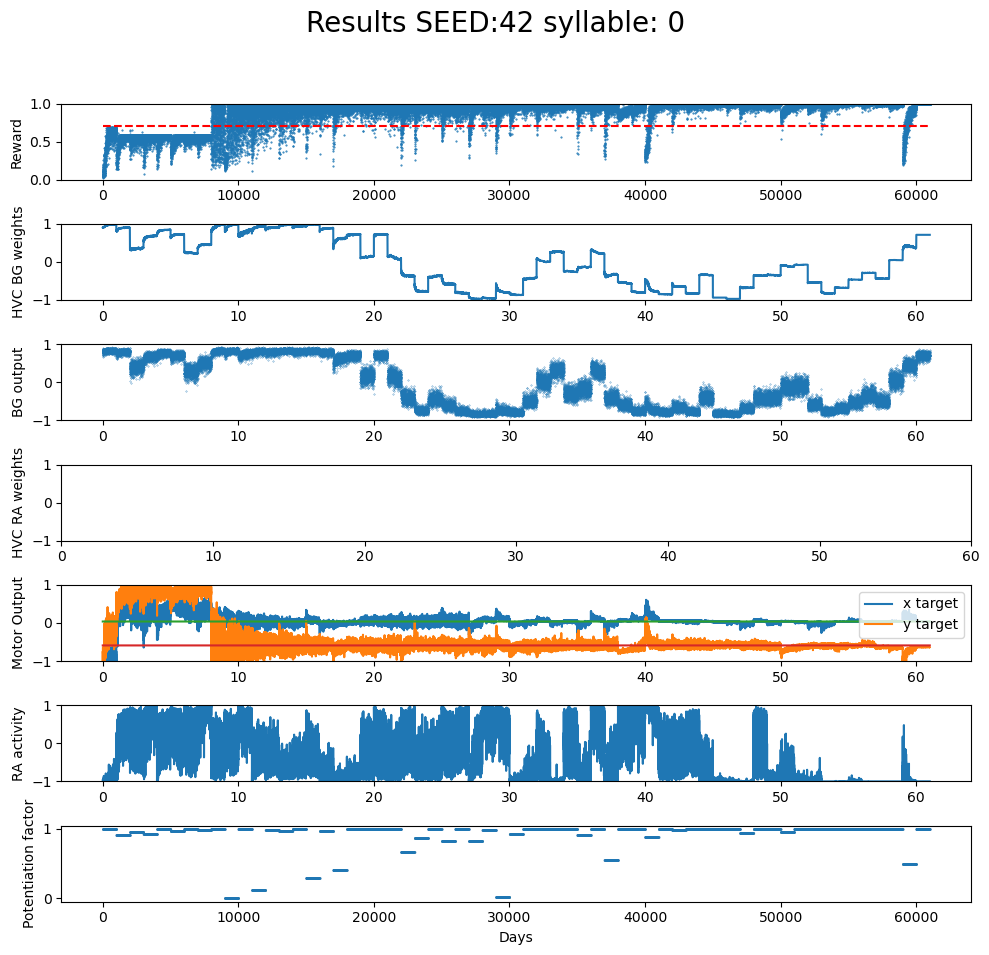

In [9]:
def plot_interal_all(obj, syll):
    fig, ax = plt.subplots(7, 1, figsize=(10, 10))  
    
    ax[0].plot(obj.rewards[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None')
    ax[0].hlines(0.7, 0, obj.DAYS * obj.TRIALS, colors='r', linestyles='dashed')
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Reward')
    
    ax[1].plot(obj.hvc_bg_array[:, :, syll].reshape(obj.DAYS * obj.TRIALS))
    ax[1].set_ylim(-1, 1)
    ax[1].set_ylabel('HVC BG weights')
    
    ax[2].plot(obj.bg_out[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=0.5, linestyle='None')
    ax[2].set_ylim(-1, 1)
    ax[2].set_ylabel('BG output')
    
    # ax[3].plot(obj.hvc_ra_array_all[:, :, syll, 0, 0].reshape(obj.DAYS * obj.TRIALS))
    ax[3].set_ylim(-1, 1)
    ax[3].set_ylabel('HVC RA weights')
    
    ax[4].plot(obj.actions[:, :, syll, 0].reshape(obj.DAYS * obj.TRIALS))
    ax[4].plot(obj.actions[:, :, syll, 1].reshape(obj.DAYS * obj.TRIALS))
    ax[4].plot(obj.centers[syll, 0] * np.ones(obj.TRIALS * obj.DAYS))
    ax[4].plot(obj.centers[syll, 1] * np.ones(obj.TRIALS * obj.DAYS))
    ax[4].legend(['x target', 'y target'])
    ax[4].set_ylabel('Motor Output')
    ax[4].set_ylim(-1, 1)
    
    ax[5].plot(obj.ra_out[:, :, syll].reshape(obj.DAYS * obj.TRIALS))
    ax[5].set_ylim(-1, 1)
    ax[5].set_ylabel('RA activity')
    ax[6].set_xlabel('Days')
    
    potentiation_factor_all = np.repeat(obj.potentiation_factor_all, N_DAILY_MOTIFS, axis=0)
    ax[6].plot(potentiation_factor_all[:, syll, 0, 0].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, label='POTENTIATION', alpha=0.1)
    ax[6].set_ylabel('Potentiation factor')
    
    for i in range(1, 6):
        ax[i].set_xticks(range(0, obj.DAYS * obj.TRIALS, 10 * obj.TRIALS), range(0, obj.DAYS, 10))
    
    fig.suptitle(f'Results SEED:{obj.seed} syllable: {syll}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore
    plt.show()


plot_interal_all(obj, 0)

In [10]:
obj.actions_bg.shape

(61, 1000, 4, 2)

In [11]:

# for i in range(N_SYLL):
#     obj.save_results(i)
    # obj.save_dw_day(i)
    # obj.save_trajectory(i)
    

No force artificial landscape


/tmp/ipykernel_149845/2931045479.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


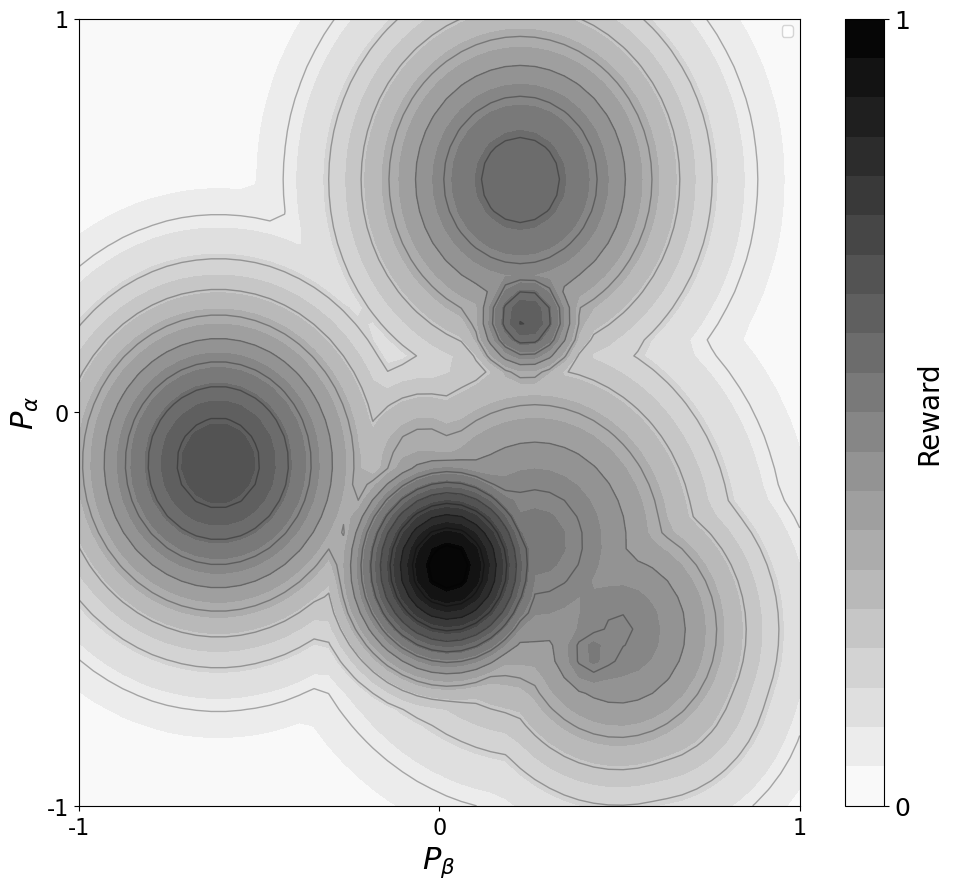

In [12]:
def plot_lansdcape(syll, force_landscape=False, landscape=1):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])
    levels_ = 20
    def plot_artificial():
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=levels_, cmap=cmap)
        axs.contour(X, Y, Z, levels=15, colors='k', linewidths=1, alpha=0.3)
        cbar = fig.colorbar(contour, ax=axs)
        cbar.set_label('Reward', fontsize=20)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0,1])

        axs.set_xticks([-limit, 0, limit], [-1, 0, 1])
        axs.set_yticks([-limit, 0, limit], [-1, 0, 1])

    def plot_syrinx():
        if obj.N_SYLL > 4:
            raise ValueError('Only 4 syllables are available in the syrinx landscape')
        obj.syrinx_contours = []
        obj.syrinx_targets = []
        for j in range(obj.N_SYLL):
            base = np.load(f"contours/Syll{j+1}.npy")
            Z, target = make_contour(base)
            obj.syrinx_contours.append(Z)
            obj.syrinx_targets.append(target)
        obj.centers = np.array(obj.syrinx_targets)
        obj.syrinx_contours = np.array(obj.syrinx_contours)
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        axs.contour(Z.T, levels=levels_, extent=[-1, 1, -1, 1], colors='k', linewidths=0.5, alpha=0.3)
        cs = axs.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1], levels=levels_)
        cbar = fig.colorbar(cs, ax = axs)
        cbar.set_label('Reward', fontsize=20)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0,1])
        axs.set_xticks([-1, 0, 1], [-1, 0, 1])
        axs.set_yticks([-1, 0, 1], [-1, 0, 1])
        # axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    if not force_landscape:
        if obj.LANDSCAPE == 0:
            print("No force artificial landscape")
            plot_artificial()
        else:
            plot_syrinx()
    else:
        if landscape == 0:
            plot_artificial()
        else:
            plot_syrinx()

    axs.set_ylabel(r'$P_{\alpha}$', fontsize=22)
    axs.set_xlabel(r'$P_{\beta}$', fontsize=22)
    axs.tick_params(labelsize=16)
    axs.legend()
    plt.tight_layout()
    plt.show()



# for i in range(N_SYLL):
plot_lansdcape(0, force_landscape=0, landscape= 1)

In [13]:

expanded_dw_day = np.zeros((DAYS*N_DAILY_MOTIFS))
def plot_dw_day(syll):
    if obj.annealing:
        fig, axs = plt.subplots(5,1,figsize=(6, 10))
        expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))

        expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))

        # Expand dw_day_array and pot_array to match the size of rewards
        expanded_dw_day_array = np.repeat(obj.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.dw_day_array[:, syll]))
        expanded_dw_day = expanded_dw_day_array.reshape(DAYS*N_DAILY_MOTIFS)
        expanded_pot_array = np.repeat(obj.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.pot_array[:, syll]))
        fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
        axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
        axs[0].plot(obj.annealing_mids[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[0].set_ylabel('dW_day = mean(abs(dw_hvc_bg))')         
        axs[0].set_ylim(0,9) 
        axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
        axs[1].set_ylabel('Size of night jump')
        axs[1].set_ylim(0, 1)
        axs[2].plot(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
        axs[2].set_ylabel('Rewards')
        axs[2].set_ylim(0, 1)
        axs[3].plot(obj.RPE[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE', alpha = 0.1)               
        axs[3].set_ylabel('RPE')
        axs[3].set_ylim(-1, 1)
        axs[4].plot(obj.RPE_SUM[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE_SUM', alpha = 0.1)
        axs[4].set_ylabel('RPE sum for a day')
        axs[4].set_ylim(-1, 4)    
        for i in range(5):
            axs[i].vlines(range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS), -3, 10, colors='black', linestyles='dashed', alpha = 0.1)           
        plt.tight_layout()
        plt.show()


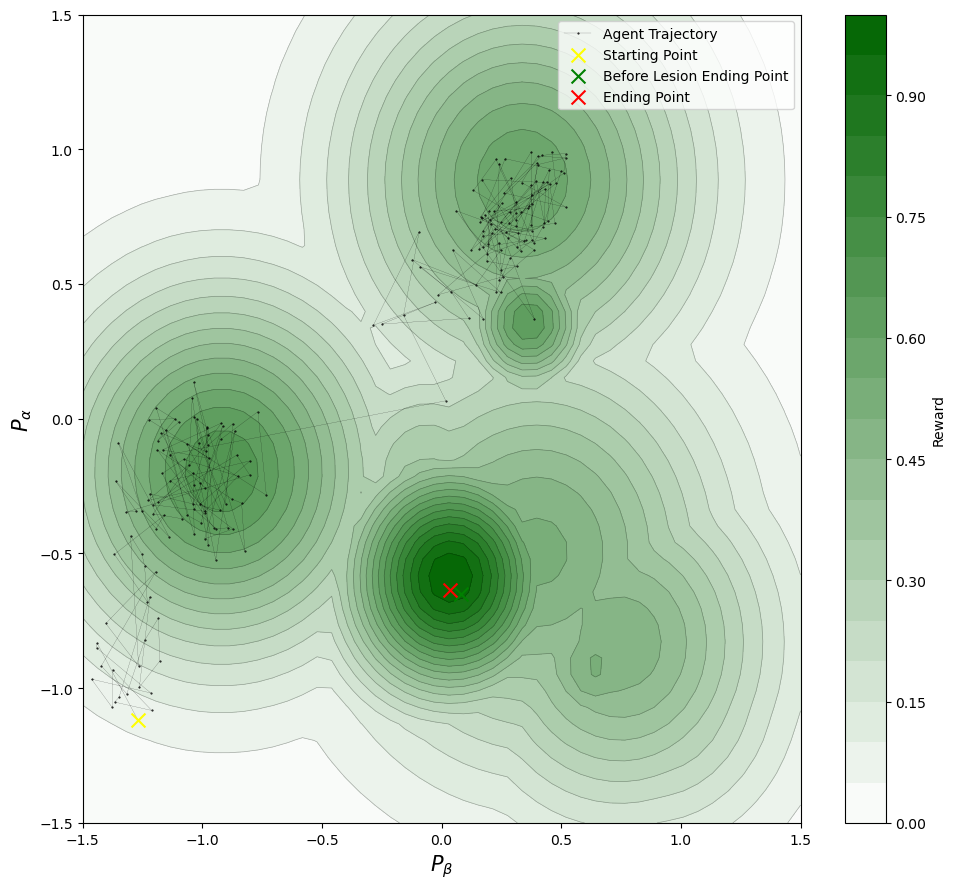

In [14]:
def plot_spec_traj(syll, day_i, day_f, every_nth_point):   
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'darkgreen'])
    if obj.LANDSCAPE == 0:
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=20, cmap=cmap)
        axs.contour(X, Y, Z, levels=20, colors='k', linewidths=0.5, alpha=0.3)
        fig.colorbar(contour, ax=axs, label='Reward')
    else:
        if obj.N_SYLL > 4:
            raise ValueError('Only 4 syllables are available in the syrinx landscape')
        obj.syrinx_contours = []
        obj.syrinx_targets = []
        for j in range(obj.N_SYLL):
            base = np.load(f"contours/Syll{j+1}.npy")
            Z, target = make_contour(base)
            obj.syrinx_contours.append(Z)
            obj.syrinx_targets.append(target)
            obj.centers = np.array(obj.syrinx_targets)
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = plt.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1], levels=20, linewidths=0.5)
        fig.colorbar(cs, ax=axs, label='Reward')
        # axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='target')  # type: ignore
        # plot trajectory

        axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')
    x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
    axs.plot(x_traj[day_i*TRIALS: day_f*TRIALS][::every_nth_point], y_traj[day_i*TRIALS: day_f*TRIALS][::every_nth_point], 'black', label='Agent Trajectory', alpha = 1, linewidth = 0.1, marker='.', markersize = 0.99) # Plot every 20th point for efficiency
    axs.scatter(x_traj[0], y_traj[0], s=100, c='yellow', label='Starting Point', marker = 'x',zorder = 2)  # type: ignore # Plot first point as red circle
    axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='green', marker='x', label='Before Lesion Ending Point', zorder=3)
    axs.scatter(x_traj[-1], y_traj[-1], s=100, c='r', marker='x', label='Ending Point',zorder=3) # type: ignore
    
    # labels
    # axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}', fontsize = 15)
    axs.set_ylabel(r'$P_{\alpha}$', fontsize=15)
    axs.set_xlabel(r'$P_{\beta}$', fontsize=15)
    axs.legend()
    plt.tight_layout()
    plt.show()

plot_spec_traj(0, 0, 2,10)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

def plot_traj_hist(syll):
    x_traj, y_traj = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    x_traj = np.array(x_traj)
    y_traj = np.array(y_traj)

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig)

    # Axes layout
    ax_main = fig.add_subplot(gs[1: , 0:3])    # Main trajectory plot
    ax_xhist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)  # X histogram
    ax_yhist = fig.add_subplot(gs[1:, 3], sharey=ax_main)   # Y histogram

    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'slateblue'])
    # cmap = 'viridis'

    if obj.LANDSCAPE == 0:
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = ax_main.contourf(X, Y, Z, levels=20, cmap=cmap)
        # fig.colorbar(contour, ax=ax_main, label='Reward')
    else:
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
        # fig.colorbar(cs, ax=ax_main, label='Reward')
        ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    # Plot trajectory on main axis
    ax_main.plot(x_traj[::10], y_traj[::10], 'black', label='Agent Trajectory', alpha=0.3, linewidth=0.1, marker='.', markersize=0.99)
    ax_main.scatter(x_traj[0], y_traj[0], s=100, c='yellow', label='Starting Point', marker='x', zorder=2)
    ax_main.scatter(x_traj[-1001], y_traj[-1001], s=100, c='green', marker='x', label='Before Lesion Ending Point', zorder=3)
    ax_main.scatter(x_traj[-1], y_traj[-1], s=100, c='r', marker='x', label='Ending Point', zorder=3)

    ax_main.set_ylabel(r'$P_{\alpha}$')
    ax_main.set_xlabel(r'$P_{\beta}$')
    # ax_main.legend()

    # Histograms
    # ---------------- X-Axis Histogram ----------------
    group_size = 10
    num_groups = DAYS // group_size
    colors = cm.get_cmap('seismic', num_groups)

    # Compute common bin edges for X
    num_bins = 40
    x_bin_edges = np.linspace(x_traj.min(), x_traj.max(), num_bins + 1)

    for group in range(num_groups):
        start_day = group * group_size
        end_day = (group + 1) * group_size
        start_idx = start_day * TRIALS
        end_idx = end_day * TRIALS

        ax_xhist.hist(
            x_traj[start_idx:end_idx],
            bins=x_bin_edges,
            alpha=0.5,
            color=colors(group),
            edgecolor='black'
        )

    ax_xhist.set_yticks([])
    ax_xhist.spines['top'].set_visible(False)
    ax_xhist.spines['right'].set_visible(False)
    ax_xhist.spines['left'].set_visible(False)

    # ---------------- Y-Axis Histogram ----------------

    # Compute common bin edges for Y
    y_bin_edges = np.linspace(y_traj.min(), y_traj.max(), num_bins + 1)

    for group in range(num_groups):
        start_day = group * group_size
        end_day = (group + 1) * group_size
        start_idx = start_day * TRIALS
        end_idx = end_day * TRIALS

        ax_yhist.hist(
            y_traj[start_idx:end_idx],
            bins=y_bin_edges,
            orientation='horizontal',
            alpha=0.5,
            color=colors(group),
            edgecolor='black'
        )

    ax_yhist.set_xticks([])
    ax_yhist.spines['top'].set_visible(False)
    ax_yhist.spines['right'].set_visible(False)
    ax_yhist.spines['bottom'].set_visible(False)


    # Remove labels to avoid clutter
    plt.setp(ax_xhist.get_xticklabels(), visible=False)
    plt.setp(ax_yhist.get_yticklabels(), visible=False)
    ax_xhist.set_ylabel("Freq (X)")
    ax_yhist.set_xlabel("Freq (Y)")

    plt.tight_layout()
    plt.show()

# plot_traj_hist(0)

/tmp/ipykernel_149845/3234704011.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('bwr', num_groups)


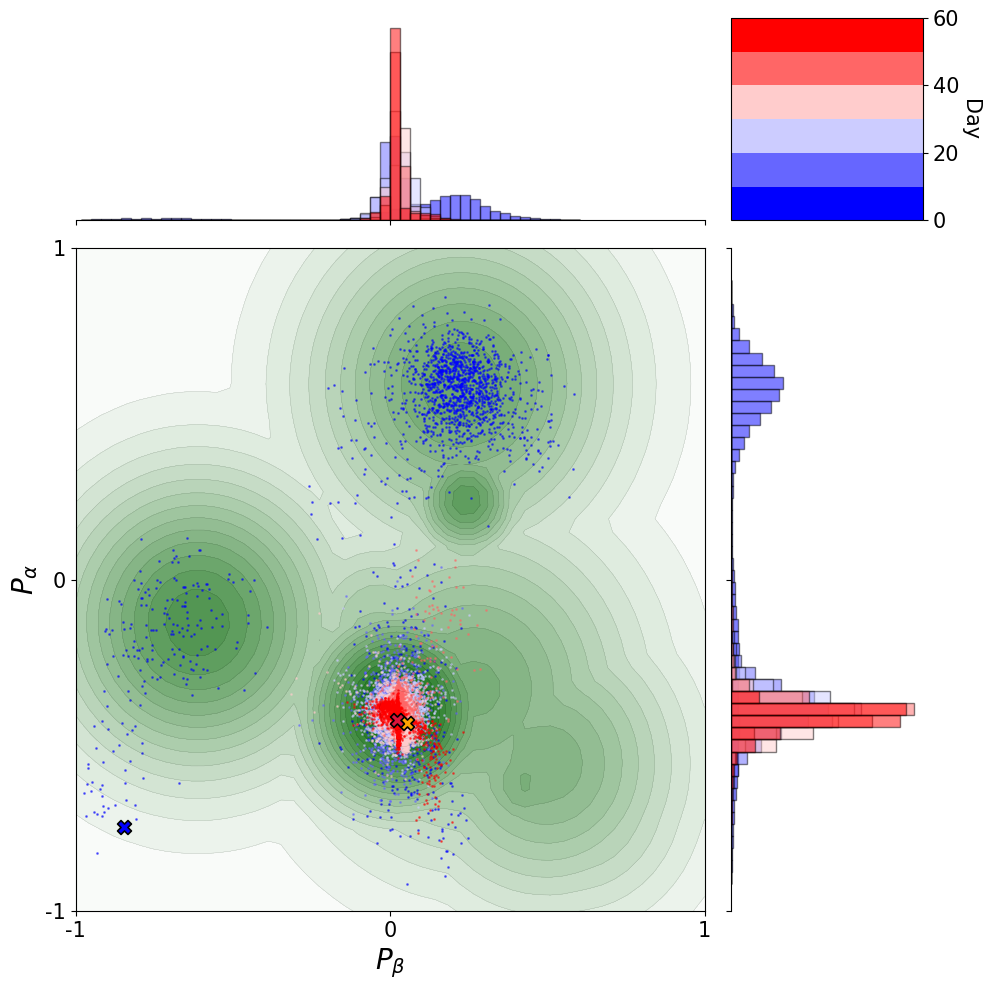

In [16]:
def plot_traj_with_RA(syll):
    # Motor trajectory
    x_motor, y_motor = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    x_motor = np.array(x_motor)
    y_motor = np.array(y_motor)

    # RA contribution trajectory
    ra_actions = obj.actions - obj.actions_bg
    x_ra, y_ra = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_ra = np.array(x_ra)
    y_ra = np.array(y_ra)

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig)

    # Axes layout
    ax_main = fig.add_subplot(gs[1:, 0:3])    # Main trajectory plot
    ax_xhist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)  # X histogram
    ax_yhist = fig.add_subplot(gs[1:, 3], sharey=ax_main)   # Y histogram
    ax_cbar = fig.add_subplot(gs[0, 3])  # Colorbar axis

    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'darkgreen'])

    if obj.LANDSCAPE == 0:
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = ax_main.contourf(X, Y, Z, levels=20, cmap=cmap)
        ax_main.contour(X, Y, Z, levels=20, colors='k', linewidths=0.2, alpha=0.3)

    else:
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
        ax_main.contour(X, Y, Z, levels=20, colors='k', linewidths=0.2, alpha=0.3)
        ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    # Motor trajectory start, mid, end points
    ax_main.scatter(x_motor[0], y_motor[0], s=100, c='blue', marker='X', label='Start of Learning', edgecolor='black', linewidth=1.2, zorder=3)
    ax_main.scatter(x_motor[BG_INTACT_DAYS * TRIALS - 1], y_motor[BG_INTACT_DAYS * TRIALS - 1], s=100, c='orange', marker='X', label='End Before Lesion', edgecolor='black', linewidth=1.2, zorder=3)
    ax_main.scatter(x_motor[-1], y_motor[-1], s=100, c='crimson', marker='X', label='After Lesion', edgecolor='black', linewidth=1.2, zorder=3)

    ax_main.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    ax_main.set_xlabel(r'$P_{\beta}$', fontsize=20)
    ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
    ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)

    # Grouped motor trajectory
    group_size = 10
    num_groups = DAYS // group_size
    colors = cm.get_cmap('bwr', num_groups)

    num_bins = 50
    x_bin_edges = np.linspace(x_motor.min(), x_motor.max(), num_bins + 1)
    y_bin_edges = np.linspace(y_motor.min(), y_motor.max(), num_bins + 1)

    for group in range(num_groups):
        start_day = group * group_size
        end_day = (group + 1) * group_size
        start_idx = start_day * TRIALS
        end_idx = end_day * TRIALS

        ax_xhist.hist(x_motor[start_idx:end_idx], bins=x_bin_edges, alpha=0.5, color=colors(group), edgecolor='black')
        ax_yhist.hist(y_motor[start_idx:end_idx], bins=y_bin_edges, orientation='horizontal', alpha=0.5, color=colors(group), edgecolor='black')
        ax_main.scatter(x_motor[start_idx:end_idx:5], y_motor[start_idx:end_idx:5], color=colors(group), s=1, alpha=0.5)

    # Plot RA contribution
    # ax_main.plot(x_ra[::100], y_ra[::100], color='maroon', lw=2, label='RA contribution')

    # ax_main.legend()

    # Styling histograms
    ax_xhist.set_yticks([])
    ax_xhist.spines['top'].set_visible(False)
    ax_xhist.spines['right'].set_visible(False)
    ax_xhist.spines['left'].set_visible(False)

    ax_yhist.set_xticks([])
    ax_yhist.spines['top'].set_visible(False)
    ax_yhist.spines['right'].set_visible(False)
    ax_yhist.spines['bottom'].set_visible(False)

    plt.setp(ax_xhist.get_xticklabels(), visible=False)
    plt.setp(ax_yhist.get_yticklabels(), visible=False)
    # ax_xhist.set_ylabel("Freq (X)")
    # ax_yhist.set_xlabel("Freq (Y)")

    # Colorbar for groups
    norm = Normalize(vmin=0, vmax=num_groups * group_size)
    sm = ScalarMappable(cmap=colors, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, cax=ax_cbar, orientation='vertical')
    cbar.set_label('Day', rotation=270, labelpad=15, fontsize=15)
    cbar.set_ticks([group_size * i*2 for i in range(num_groups//2+1)])
    cbar.ax.tick_params(labelsize=15)
    # cbar.set_ticklabels([f"{group_size * i}" for i in range(num_groups + 1)])

    plt.tight_layout()
    plt.show()

# Usage
plot_traj_with_RA(0)


Rows: 1, Cols: 6


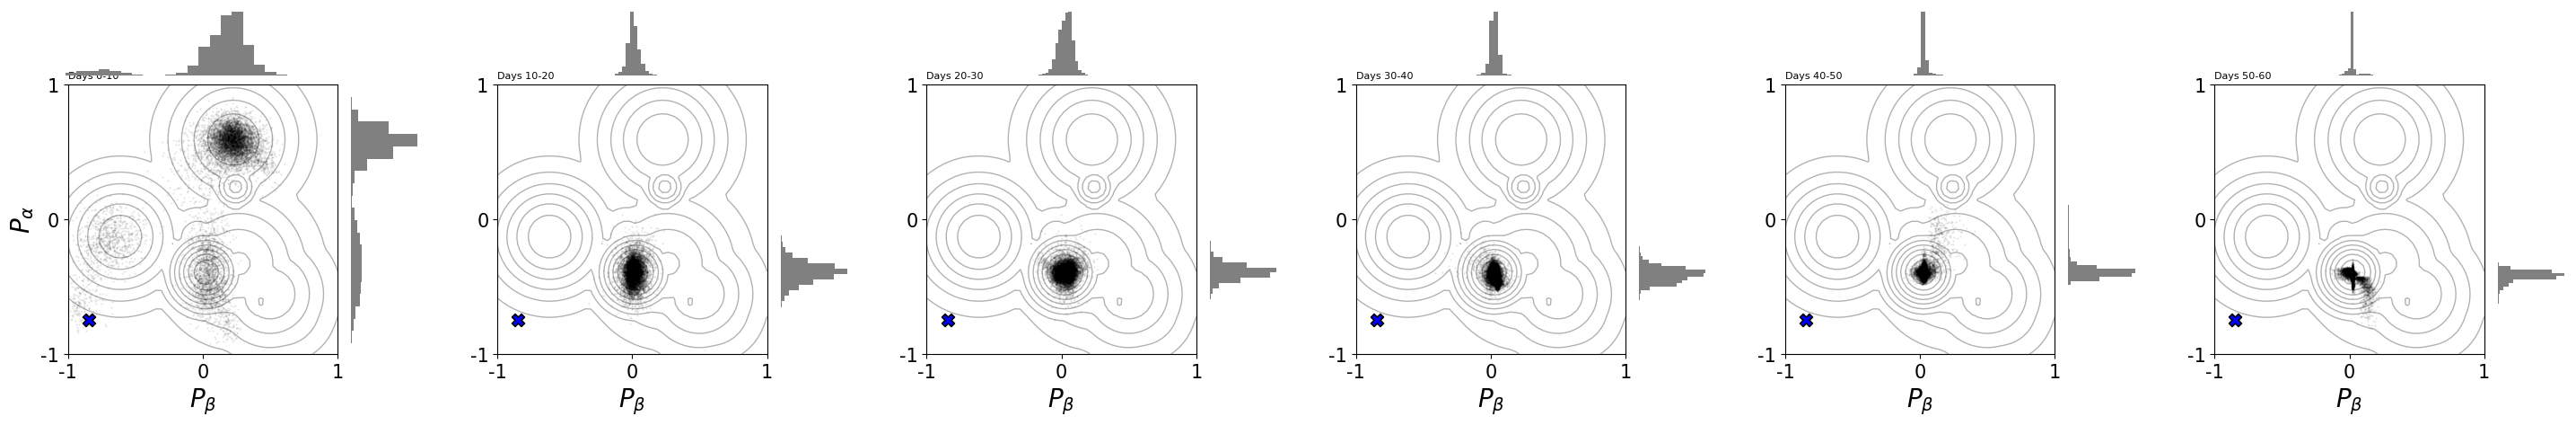

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
import math

def plot_traj_panels(syll):
    # Motor trajectory
    x_motor, y_motor = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))

    # RA contribution trajectory
    ra_actions = obj.actions - obj.actions_bg
    x_ra, y_ra = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_ra = np.array(x_ra)
    y_ra = np.array(y_ra)

    # Settings
    group_size = 10
    num_groups = DAYS // group_size
    rows = 1
    cols = num_groups

    # Create full figure with two parts: 1 row for main panel, rest for subplots
    full_fig = plt.figure(figsize=(6 * cols,  5 * rows))  # dynamic height
    full_gs = GridSpec(nrows=rows, ncols=cols, figure=full_fig, height_ratios= [1] * rows, hspace=0.6)
    print(f"Rows: {rows}, Cols: {cols}")
    # ==== Main Panel (first row, spanning all columns) ====
    # ax_main = full_fig.add_subplot(full_gs[0, :])

    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])


    # ==== Subplots for group trajectories ====
    for group in range(num_groups):
        r = (group // cols)   # +1 because row 0 is for main panel
        c = group % cols
        outer_spec = GridSpecFromSubplotSpec(2, 2,
                                             width_ratios=[4, 1], height_ratios=[1, 4],
                                             subplot_spec=full_gs[r, c], wspace=0.05, hspace=0.05)

        ax_main = full_fig.add_subplot(outer_spec[1, 0])
        ax_xhist = full_fig.add_subplot(outer_spec[0, 0], sharex=ax_main)
        ax_yhist = full_fig.add_subplot(outer_spec[1, 1], sharey=ax_main)

        start_idx = group * group_size * TRIALS
        end_idx = (group + 1) * group_size * TRIALS
        traj_x = x_motor[start_idx:end_idx]
        traj_y = y_motor[start_idx:end_idx]

        ax_main.plot(traj_x, traj_y, color='black', alpha=0.1, lw= 0, marker='.', markersize=1) 
        ax_main.set_xlim([-1.5, 1.5])
        ax_main.set_ylim([-1.5, 1.5])
        ax_main.set_xticks([])
        ax_main.set_yticks([])
        ax_main.set_aspect('equal')
        ax_main.set_title(f"Days {group * group_size}-{(group + 1) * group_size}", fontsize=8, loc='left', pad=5)

        ax_xhist.hist(traj_x, bins=20, color='gray')
        ax_yhist.hist(traj_y, bins=20, color='gray', orientation='horizontal')
        ax_xhist.axis('off')
        ax_yhist.axis('off')

        if obj.LANDSCAPE == 0:
            limit = obj.limit
            x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
            X, Y = np.meshgrid(x, y)
            Z = obj.get_reward([X, Y], syll)
            # ax_main.contourf(X, Y, Z, levels=20, cmap=cmap)
            ax_main.contour(X, Y, Z, levels=10, colors='k', linewidths=1, alpha=0.3)
        else:
            Z = obj.syrinx_contours[syll]
            target_pos = obj.syrinx_targets[syll]
            ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
            ax_main.contour(Z.T, levels=10, colors='k', linewidths=1, alpha=0.3)
            ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

        # Learning trajectory markers
        # ax_main.plot(x_motor, y_motor, color='C1', alpha=0.2, lw= 0, marker='.', markersize=0.5)    
        ax_main.scatter(x_motor[0], y_motor[0], s=100, c='blue', marker='X', label='Start of Learning', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[BG_INTACT_DAYS * TRIALS - 1], y_motor[BG_INTACT_DAYS * TRIALS - 1], s=100, c='orange', marker='X', label='End Before Lesion', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[-1], y_motor[-1], s=100, c='crimson', marker='X', label='After Lesion', edgecolor='black', linewidth=1.2)
        if group == 0:
            ax_main.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        ax_main.set_xlabel(r'$P_{\beta}$', fontsize=20)
        ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        # ax_main.set_title("Full Motor Trajectory", fontsize=18)
        # ax_main.legend()


    # full_fig.suptitle("Full Motor Trajectory and Grouped Segments", fontsize=22)
    # plt.tight_layout()
    plt.show()


# Usage
plot_traj_panels(0)


## Plottings

In [18]:
def running_mean(x, N=5):
        """ Returns the running average of an array. """
        rm = np.convolve(x, np.ones(N)/N, mode='valid')
        padded_rm = np.ones(np.shape(x)) * rm[-1]
        padded_rm[:rm.size] = rm

        return padded_rm

### Output

/tmp/ipykernel_149845/2190593745.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('bwr', num_groups)


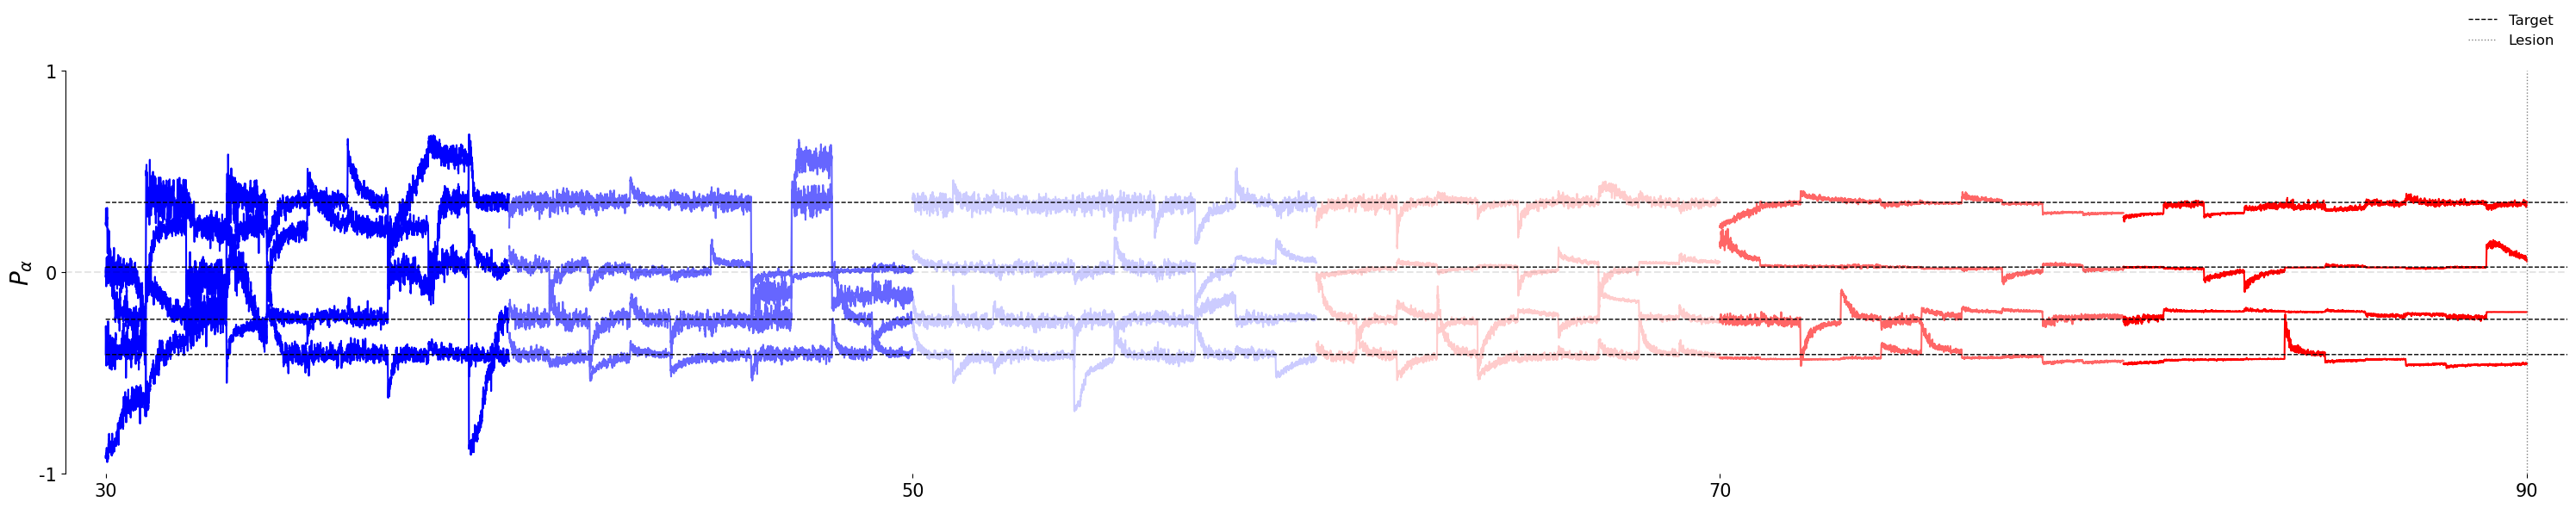

In [19]:
def plot_output(obj):
    figure, (ax1) = plt.subplots(1,1, figsize=(30, 6))
    
    sk = N_SYLL
    LIMIT = 1.5

    # Display x axis in days
    x = np.arange(N_TOTAL_TRIALS)
    x = x/(N_DAILY_MOTIFS * N_SYLL)

    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    # Data
    group_size = 10  # days
    num_groups = DAYS // group_size
    colors = cm.get_cmap('bwr', num_groups)

    for syll in range(N_SYLL):
        traj_x = obj.actions[:, :, syll, 0].reshape(DAYS * N_DAILY_MOTIFS)
        traj_y = obj.actions[:, :, syll, 1].reshape(DAYS * N_DAILY_MOTIFS)

        for g in range(num_groups):
            start_day = g * group_size
            end_day = (g + 1) * group_size
            start_idx = start_day * N_DAILY_MOTIFS
            end_idx = end_day * N_DAILY_MOTIFS

            # Time axis shifted to correct starting day
            time_segment = np.arange(end_idx - start_idx) + start_idx
            time_segment_days = time_segment 

            ax1.plot(
                time_segment_days,
                running_mean(traj_x[start_idx:end_idx], 10),
                color=colors(g),
                lw=1.5
            )
            # ax2.plot(
            #     time_segment_days,
            #     running_mean(traj_y[start_idx:end_idx], 10),
            #     color=colors(g),
            #     lw=1.5
            # )
    
    for syll in range(N_SYLL - 1):
        # target
        ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1, label = 'Target')
        # ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1)
    if N_SYLL > 1:
        ax1.plot(obj.centers[syll + 1, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1)
        # ax2.plot(obj.centers[syll + 1, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1, label = 'Target')
    elif N_SYLL == 1:
        ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1, label = 'Target')
        # ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1)
        
    # Axis beauty
    ax1.axvline(x=BG_INTACT_DAYS * TRIALS, linestyle=':', color='grey', lw=1, label='Lesion')
    # ax2.axvline(x=BG_INTACT_DAYS * TRIALS, linestyle=':', color='grey', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylim(-LIMIT, LIMIT)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1])
    ax1.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    
    # ax2.set_xlabel('Days', fontsize=20)
    # ax2.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1])  
    # ax2.set_ylim(-LIMIT, LIMIT)
    # ax2.tick_params(labelsize=15)
    # ax2.spines['top'].set_visible(False)
    # ax2.spines['right'].set_visible(False)
    # ax2.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    # # ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)
    
    # ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
    ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    # Remove duplicate legend entries
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.0, 1.1))

    # plt.legend()
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30, DAYS+30, 20))
    plt.tight_layout()
    plt.show()

plot_output(obj)

In [20]:
obj.actions.shape

(61, 1000, 4, 2)

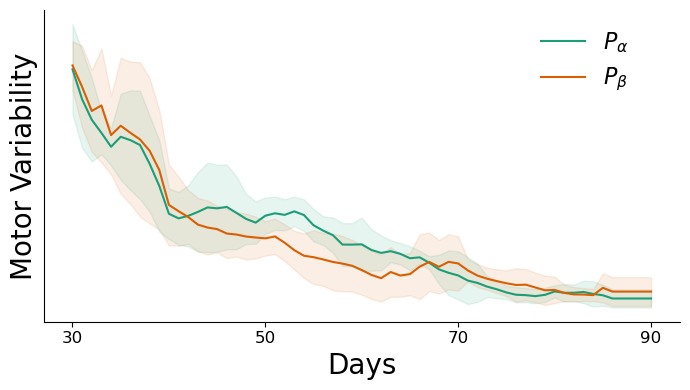

In [21]:
def plot_motor_variability(obj):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    days = np.arange(DAYS)
    all_syll_std_x = []
    all_syll_std_y = []

    for syll in range(N_SYLL):
        stds_x = []
        stds_y = []
        for day in days:
            traj_x = obj.actions[day, :, syll, 0]
            traj_y = obj.actions[day, :, syll, 1]
            stds_x.append(np.std(traj_x))
            stds_y.append(np.std(traj_y))
        all_syll_std_x.append(running_mean(stds_x, 5))
        all_syll_std_y.append(running_mean(stds_y, 5))

    all_syll_std_x = np.array(all_syll_std_x)
    all_syll_std_y = np.array(all_syll_std_y)

    mean_x = np.mean(all_syll_std_x, axis=0)
    std_x = np.std(all_syll_std_x, axis=0)
    mean_y = np.mean(all_syll_std_y, axis=0)
    std_y = np.std(all_syll_std_y, axis=0)

    # Use visually distinct and colorblind-friendly colors
    color_x = '#1b9e77'  # Teal green
    color_y = '#d95f02'  # Dark orange

    ax.plot(days, mean_x, color=color_x, label=r'$P_{\alpha}$')
    ax.fill_between(days, mean_x - std_x, mean_x + std_x, color=color_x, alpha=0.1)

    ax.plot(days, mean_y, color=color_y, label=r'$P_{\beta}$')
    ax.fill_between(days, mean_y - std_y, mean_y + std_y, color=color_y, alpha=0.1)

    # Plot settings
    ax.set_ylabel("Motor Variability", fontsize=20)
    ax.set_xlabel("Days", fontsize=20)
    ax.set_xticks(range(0, DAYS, 20), np.arange(30, DAYS + 30, 20), fontsize=15)

    ax.legend(frameon=False, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.0))
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

plot_motor_variability(obj)

In [22]:
obj.bg_all.shape

(61, 1000, 4, 8)

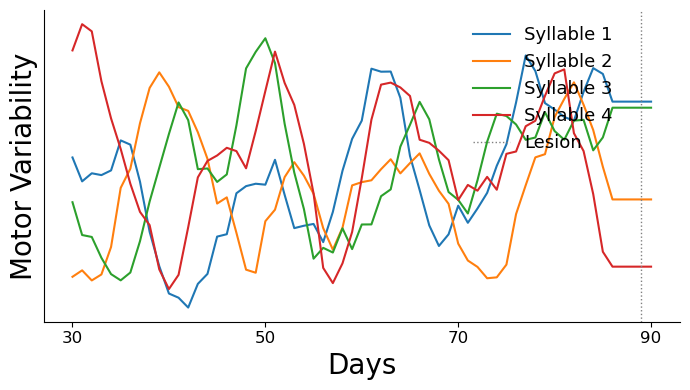

In [23]:
def plot_bg_variability(obj):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    days = np.arange(DAYS)
    for syll in range(N_SYLL):
        stds_combined = []
        for day in days:
            traj_x = obj.bg_all[day, :, syll, 0]
            traj_y = obj.bg_all[day, :, syll, 1]
            std_x = np.std(traj_x)
            std_y = np.std(traj_y)
            stds_combined.append(np.sqrt(std_x**2 + std_y**2))

        ax.plot(days, running_mean(stds_combined, 5), label=f"Syllable {syll+1}")

    # Plot settings
    ax.set_ylabel("Motor Variability", fontsize=20)
    ax.set_xlabel("Days", fontsize=20)

    # Lesion marker
    ax.axvline(BG_INTACT_DAYS-1, linestyle=':', color='grey', lw=1, label='Lesion')
    ax.set_xticks(range(0, DAYS, 20), np.arange(30, DAYS+30, 20), fontsize=15)

    # Legends and aesthetics
    ax.legend(frameon=False, fontsize=13, loc='upper left', bbox_to_anchor=(0.65, 1.0))  # shifted right
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

plot_bg_variability(obj)

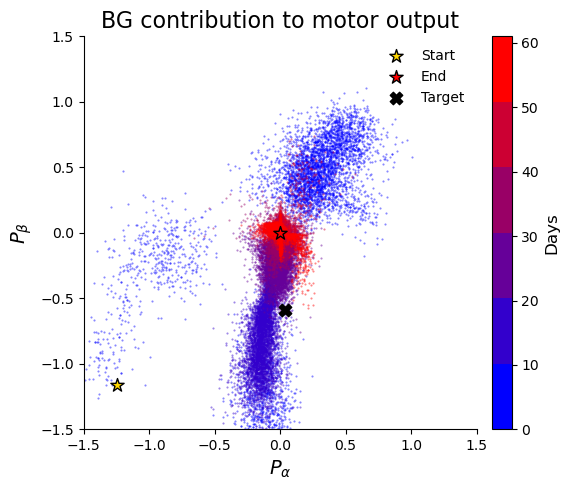

In [24]:
def plot_BG_traj(syll, group_size=10):
    x_traj, y_traj = zip(*obj.actions_bg[:, :, syll, :].reshape(-1, 2))
    x_traj = np.array(x_traj)
    y_traj = np.array(y_traj)

    fig, ax = plt.subplots(figsize=(8, 5))

    num_groups = DAYS // group_size
    cmap = LinearSegmentedColormap.from_list('blue_to_red', ['blue', 'red'], N=num_groups)
    # cmap = cm.get_cmap('seismic', num_groups)
    norm = Normalize(vmin=0, vmax=DAYS)

    for g in range(num_groups):
        start_day = g * group_size
        end_day = (g + 1) * group_size
        start_idx = start_day * N_DAILY_MOTIFS
        end_idx = end_day * N_DAILY_MOTIFS

        ax.plot(
            x_traj[start_idx:end_idx:2],
            y_traj[start_idx:end_idx:2],
            lw=0,
            color=cmap(g),
            marker='.',
            markersize=1,
            alpha=0.5
        )

    # Mark start and end
    ax.scatter(x_traj[0], y_traj[0], s=100, c='gold', edgecolor='black', marker='*', label='Start', zorder=5)
    ax.scatter(x_traj[-1], y_traj[-1], s=100, c='red', edgecolor='black', marker='*', label='End', zorder=5)

    # Target
    ax.scatter(obj.centers[syll, 0], obj.centers[syll, 1], c='black', s=80, marker='X', label='Target', zorder=4)

    # Plot formatting
    ax.set_title(f"BG contribution to motor output", fontsize=16)
    ax.set_xlabel(r'$P_{\alpha}$', fontsize=14)
    ax.set_ylabel(r'$P_{\beta}$', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-obj.limit, obj.limit)
    ax.set_ylim(-obj.limit, obj.limit)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), frameon=False, fontsize=10)

    # Add color bar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Days', fontsize=12)
    cbar.set_ticks([i * group_size for i in range(num_groups + 1)])
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

plot_BG_traj(0)

### Reward

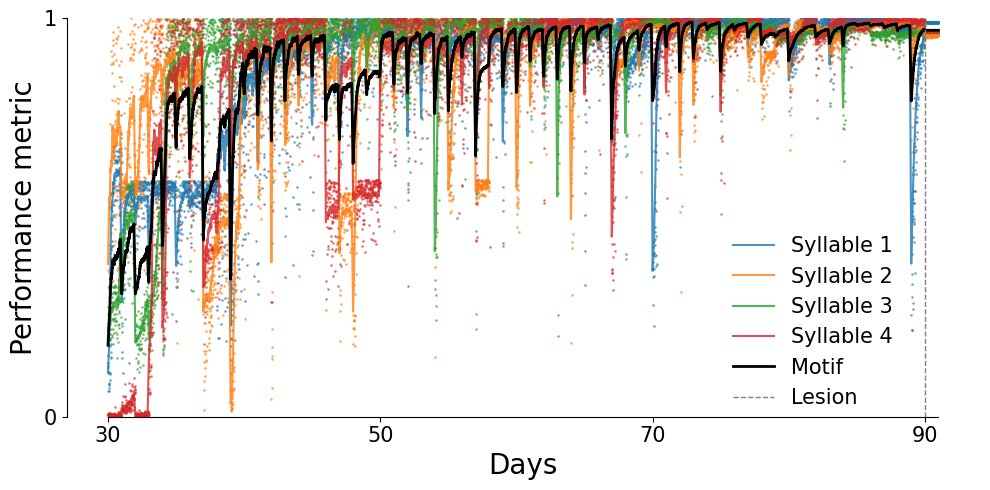

In [25]:
def plot_reward(obj):
    figure, ax = plt.subplots(1, figsize=(10, 5))

    # Clean look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Define distinct colors for syllables
    cmap = plt.get_cmap('tab10')  # You can change to 'Set1', 'tab20', etc.
    syllable_colors = [cmap(i) for i in range(N_SYLL)]

    # Plotting raw rewards (dots)
    for syll in range(N_SYLL):
        array = obj.rewards[:, :, syll].reshape(DAYS * N_DAILY_MOTIFS)[::10]
        x_new = np.linspace(0, DAYS * N_DAILY_MOTIFS, len(array))
        ax.plot(x_new, array, linewidth=0, marker='.', alpha=0.5, markersize=2, color=syllable_colors[syll])

    # Plotting running mean (lines)
    for syll in range(N_SYLL):
        smooth = running_mean(obj.rewards[:, :, syll].reshape(DAYS * N_DAILY_MOTIFS), 100)
        ax.plot(smooth, lw=1.5, alpha=0.8, color=syllable_colors[syll], label=f'Syllable {syll+1}')

    # Plot overall motif average
    mean_motif = running_mean(np.mean(obj.rewards[:, :, :].reshape(DAYS * N_DAILY_MOTIFS, N_SYLL), axis=1), 100)
    ax.plot(mean_motif, color="black", lw=2, alpha=1, label='Motif')

    # Lesion marker
    ax.axvline(x=BG_INTACT_DAYS * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1, label='Lesion')

    # Labels and ticks
    ax.set_xlabel('Days', fontsize=20)
    ax.set_ylabel('Performance metric', fontsize=20)
    ax.set_ylim(0, 1)
    ax.tick_params(labelsize=15)
    ax.spines['bottom'].set_bounds(0, DAYS * N_DAILY_MOTIFS)
    ax.set_yticks([0, 1])
    
    # Legend
    ax.legend(bbox_to_anchor=[0.925, 0.5], fontsize=15, frameon=False)

    # X-ticks in terms of days
    plt.xticks(range(0, N_DAILY_MOTIFS * DAYS, 20 * N_DAILY_MOTIFS), np.arange(30, 30 + DAYS, 20), fontsize=15)
    plt.tight_layout()
    plt.show()


plot_reward(obj)

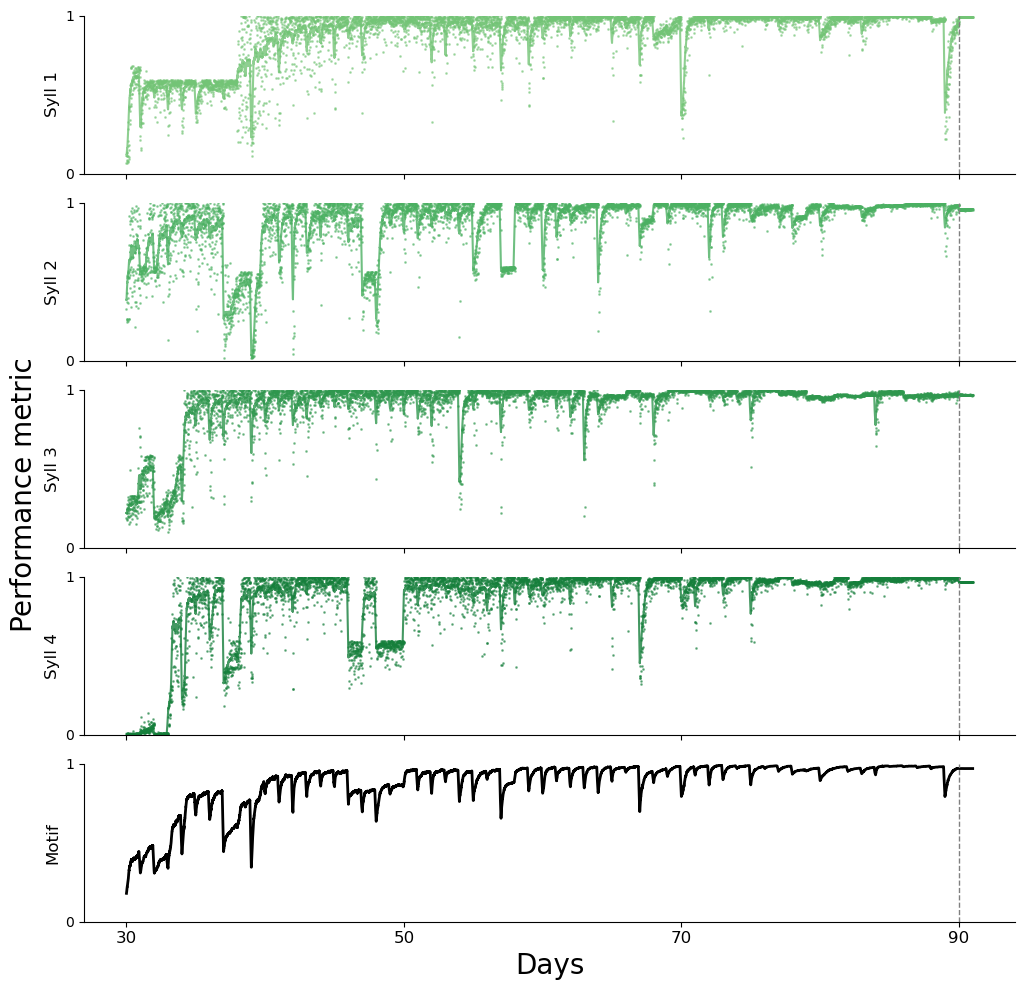

In [26]:
def plot_reward_separate(obj):
    fig, axes = plt.subplots(N_SYLL + 1, 1, figsize=(10, 2 * (N_SYLL + 1)), sharex=True)

    # Clean look for each axis
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # Define distinct colors for syllables
    cmap = plt.get_cmap('Greens')  # or 'Set1', 'tab20', etc.
    # Pick shades from dark to medium-green (avoid very light ones at the high end)
    syllable_colors = [cmap(i) for i in np.linspace(0.5, 0.8, N_SYLL)]
    x_full = np.linspace(0, DAYS * N_DAILY_MOTIFS, DAYS * N_DAILY_MOTIFS)

    # Plot for each syllable
    for syll in range(N_SYLL):
        ax = axes[syll]
        array = obj.rewards[:, :, syll].reshape(DAYS * N_DAILY_MOTIFS)[::10]
        x_array = np.linspace(0, DAYS * N_DAILY_MOTIFS, len(array))

        # Plot raw reward (dots)
        ax.plot(x_array, array, linewidth=0, marker='.', alpha=0.5, markersize=2, color=syllable_colors[syll])

        # Plot running mean
        smooth = running_mean(obj.rewards[:, :, syll].reshape(DAYS * N_DAILY_MOTIFS), 100)
        ax.plot(x_full[:len(smooth)], smooth, lw=1.5, alpha=0.8, color=syllable_colors[syll])

        # Lesion marker
        ax.axvline(x=BG_INTACT_DAYS * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)

        # Y-label per syllable
        ax.set_ylabel(f"Syll {syll+1}", fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 1])
        ax.tick_params(labelsize=10)

    # Plot for the overall motif
    ax = axes[-1]
    mean_motif = running_mean(np.mean(obj.rewards[:, :, :].reshape(DAYS * N_DAILY_MOTIFS, N_SYLL), axis=1), 100)
    ax.plot(x_full[:len(mean_motif)], mean_motif, color="black", lw=2, alpha=1)

    # Lesion marker
    ax.axvline(x=BG_INTACT_DAYS * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)

    ax.set_ylabel('Motif', fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])
    ax.tick_params(labelsize=10)

    # X-axis label only for the last subplot
    ax.set_xlabel('Days', fontsize=20)
    
    # X-ticks in terms of days
    plt.xticks(range(0, N_DAILY_MOTIFS * DAYS, 20 * N_DAILY_MOTIFS), np.arange(30, 30 + DAYS, 20), fontsize=12)
    fig.text(-0.02, 0.5, 'Performance metric', va='center', rotation='vertical', fontsize=20)
    plt.tight_layout()
    plt.show()

plot_reward_separate(obj)

### Hebbian learning trajectory

In [27]:
def plot_HL_traj(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)

    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    plot_array1 = obj.hvc_ra_array_all[:, :, 0, :].reshape(DAYS*N_DAILY_MOTIFS, 8)
    ax1.plot(plot_array1[::10, :], color='sienna', alpha=.5, linewidth=1)

    plot_array2 = obj.ra_all[:, :, 0, :].reshape(DAYS*N_DAILY_MOTIFS, 8)
    ax2.plot(plot_array2[::100, :], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

    
    # # Axis beauty
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS//10, linestyle='--', color='grey', lw=1)
    ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS//100, linestyle='--', color='grey', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(labelsize=15)
    ax1.set_xticks([])
    ax1.set_yticks([-1, 0, 1])
    ax1.set_ylim(-1.1, 1.1)

    ax2.set_xticks([0, 20*N_DAILY_MOTIFS//100, 40*N_DAILY_MOTIFS//100, 60*N_DAILY_MOTIFS//100], np.arange(30, 30+DAYS, 20)) 
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-1, 0, 1])
    ax2.tick_params(labelsize=15)

    # ax2.get_xaxis().set_ticks([0, 20, 40, 60])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS//100)



#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('RA\nactivity', fontsize=20)
    
# print(obj.hvc_ra_array_all.shape)
# plot_HL_traj(obj)

### Reinforcement Learning trajectory

In [28]:
def plot_BG_volatility(obj):
    figure, (ax1) = plt.subplots(1, figsize=(10, 4))
    for syll in range(N_SYLL):
        ax1.plot(running_mean(obj.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),30), color='grey', alpha=0.8, linewidth=2)
    # ax1.plot(running_mean(obj.bg_out[:,:,0].reshape(DAYS*N_DAILY_MOTIFS),30), color='grey', alpha=0.8, linewidth=2) 
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)     
    [ax1.axvline(x = k, linestyle='-', color='black', alpha=0.1) for k in range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS)]    
    ax1.set_xlabel('Days', fontsize=20)
    ax1.set_ylabel('BG output', fontsize=20)
    ax1.set_ylim(-1, 1)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-1, 0, 1])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)   
    ax1.set_ylim(-1, 1 )
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)

#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
    ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
#         ax2.set_ylabel('BG\nactivity', fontsize=20)

#         ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    
#         plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30,30+ DAYS, 20))    
    plt.tight_layout()

# plot_BG_volatility(obj)

### Hebbian Learning Activity

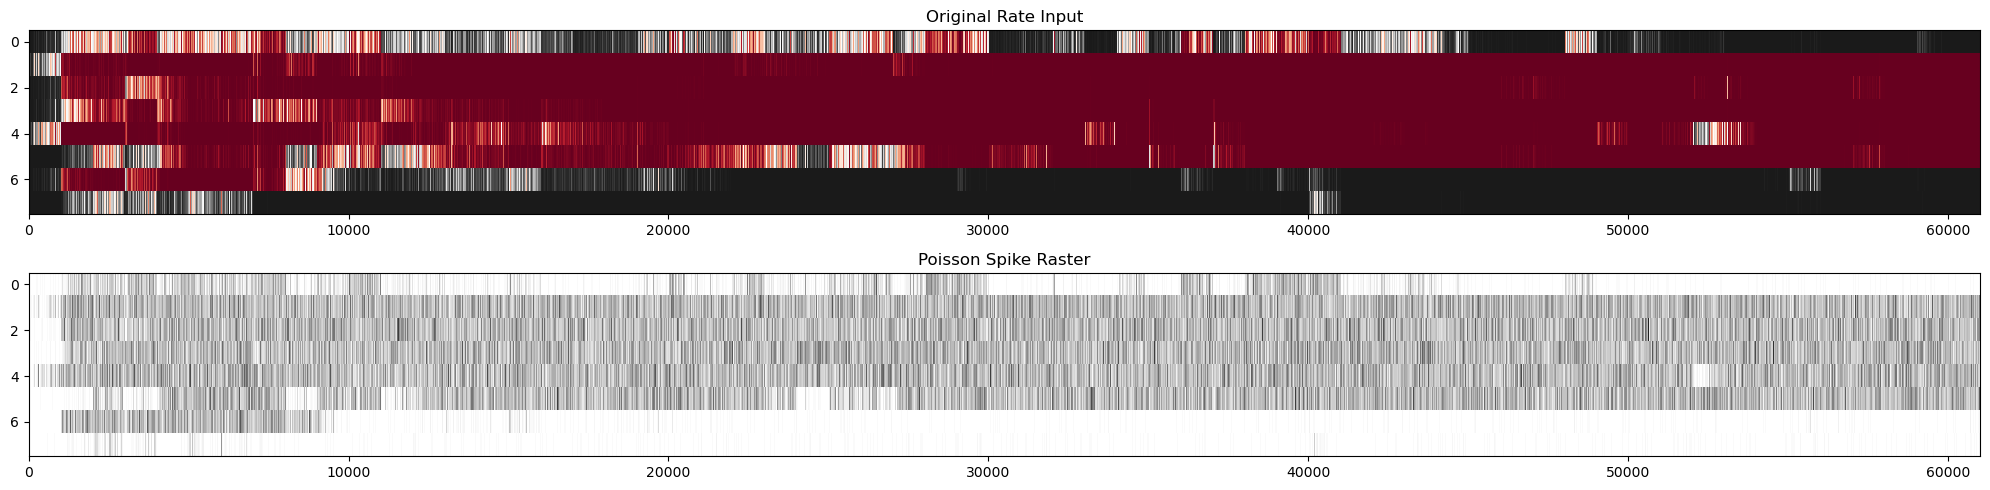

In [29]:
import numpy as np
import matplotlib.pyplot as plt
# Generate Poisson spikes from a 2D rate array
def generate_poisson_spikes(rate_array, factor=1): # input of an array with values from 0 to 1
    return np.random.poisson(lam= factor*rate_array, size= rate_array.shape)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 5))

# Reshape your input array
array1 = obj.ra_all.reshape(DAYS * N_DAILY_MOTIFS, N_SYLL, 8)[:, :]

# Show original rate (1st channel)
axs[0].imshow(array1[:, 0, :].T, aspect='auto', cmap='RdGy_r', interpolation='nearest')
axs[0].set_title("Original Rate Input")

# Generate spike raster from sigmoid-transformed rates
# rate_input = sigmoid(array1[:, 0, :].T, m=4, a=0)
spike_raster = generate_poisson_spikes(sigmoid(array1[:, 0, :].T, m=4, a=0), factor=10)

# Show spikes
im = axs[1].imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')
axs[1].set_title("Poisson Spike Raster")

plt.tight_layout()
plt.show()


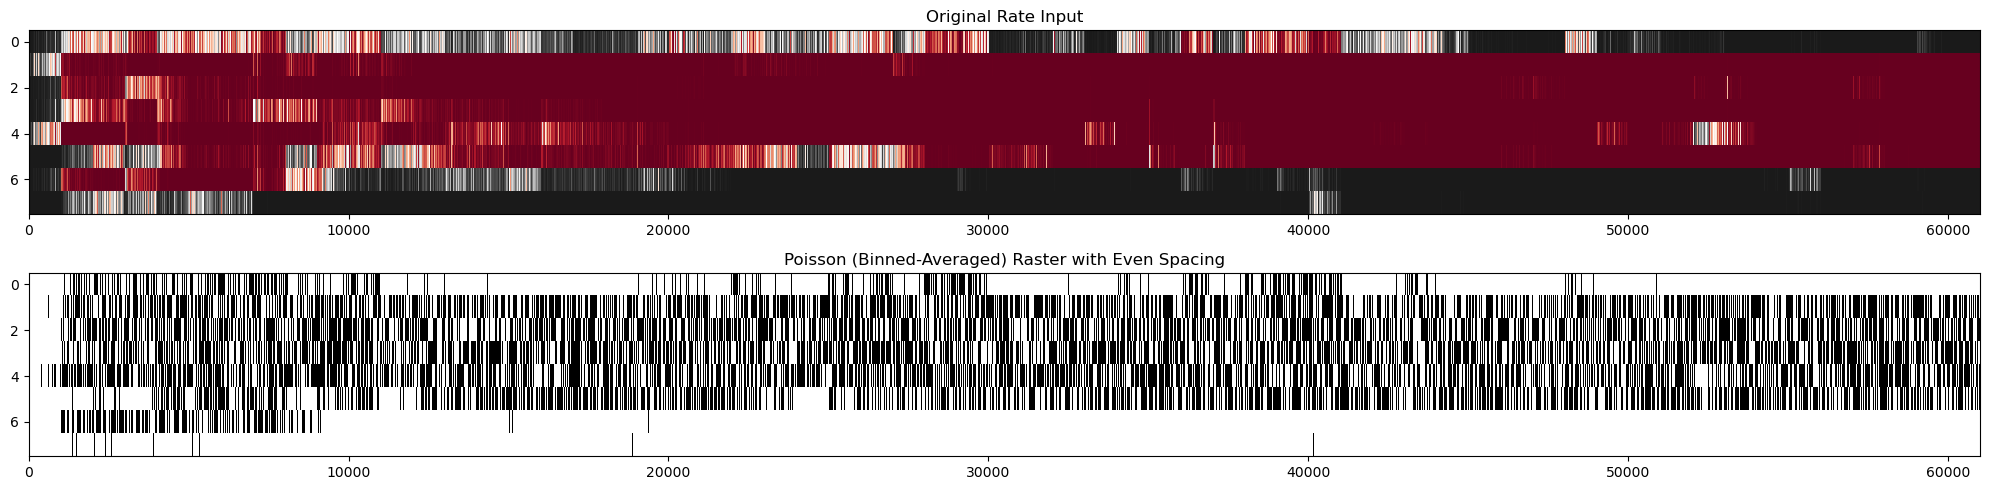

In [30]:
def bin_and_plot_spikes(rate_array, bin_size=100, factor=100):
    """
    Bins the rate array, samples spike count using Poisson(mean_rate), and
    plots evenly spaced spikes within each bin for visualization.
    Args:
        rate_array: shape (time, channels)
    """
    time, channels = rate_array.shape
    num_bins = time // bin_size

    # Prepare raster for plotting
    spike_raster_clean = np.zeros_like(rate_array)

    for c in range(channels):
        for b in range(num_bins):
            start = b * bin_size
            end = (b + 1) * bin_size

            mean_rate = np.mean(rate_array[start:end, c])  # [0, 1]
            spike_count = np.random.poisson(factor * mean_rate)

            if spike_count > 0:
                # Choose evenly spaced time bins in the interval
                spike_indices = np.linspace(start, end - 1, spike_count, dtype=int)
                spike_raster_clean[spike_indices, c] = 1
    return spike_raster_clean

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(20, 5))



# Reshape your input array
array1 = obj.ra_all.reshape(DAYS * N_DAILY_MOTIFS, N_SYLL, 8)[:, :]
rate_input = sigmoid(array1[:, 0, :], m=4, a=0)

spike_raster_clean = bin_and_plot_spikes(rate_input, bin_size=100, factor=60)

axs[0].imshow(array1[:, 0, :].T, aspect='auto', cmap='RdGy_r', interpolation='nearest')
axs[0].set_title("Original Rate Input")

axs[1].imshow(spike_raster_clean.T, aspect='auto', cmap='Greys', interpolation='nearest')
axs[1].set_title("Poisson (Binned-Averaged) Raster with Even Spacing")

plt.tight_layout()
plt.show()

/tmp/ipykernel_149845/1828140660.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/tmp/ipykernel_149845/1828140660.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


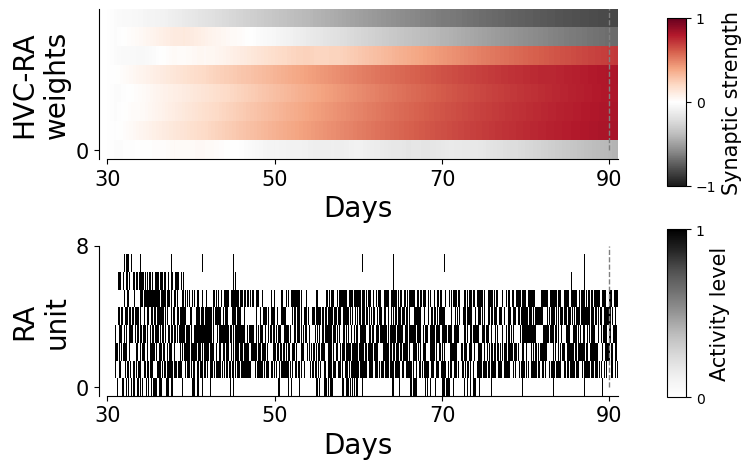

In [31]:

def plot_HL2(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)
    # ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    # ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    cm = plt.cm.get_cmap('RdGy_r')

    plot_array1 = obj.hvc_ra_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    im1 = ax1.imshow(plot_array1[:,0,:].T, cmap=cm, aspect='auto', interpolation='none', vmin = -1, vmax = 1)

    plot_array2 = obj.ra_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    spike_raster = bin_and_plot_spikes(sigmoid(plot_array2[:, 0, :], m=4, a=0), factor = 60, bin_size=100).T
    im2 = ax2.imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35]) # type: ignore
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([-1, 0, 1])
    
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35]) # type:ignore
    cbar = figure.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Activity level', fontsize=15)
    cbar.set_ticks([0, 1])

    ax1.vlines(BG_INTACT_DAYS * N_DAILY_MOTIFS, 0, 8, color='grey', linestyle='--', lw=1)   
    ax2.vlines(BG_INTACT_DAYS * N_DAILY_MOTIFS, 0, 8, color='grey', linestyle='--', lw=1)
    # ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20))     
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 8])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax1.set_ylim(-0.5, 7.5)
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax2.set_ylim(-0.5, 7.5)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 8])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20)) 
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS) 

    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('RA\nunit', fontsize=20) 
    plt.tight_layout()



# print(obj.hvc_ra_array_all.shape)    
# print(obj.hvc_ra_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.hvc_size*obj.ra_size).shape)
plot_HL2(obj)



### Reinforcement learning Activity

/tmp/ipykernel_149845/2884228105.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Greys')
/tmp/ipykernel_149845/2884228105.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


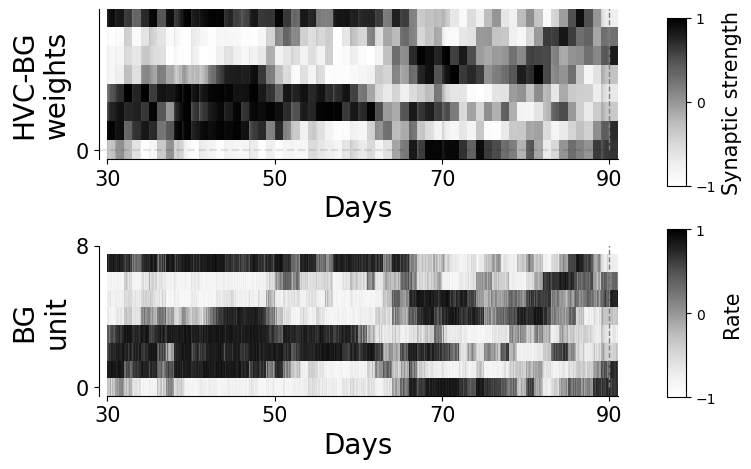

In [32]:
def plot_BG(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)

    cm = plt.cm.get_cmap('Greys')
    plot_array1 = obj.hvc_bg_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    im1 = ax1.imshow(plot_array1[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')
    plot_array2 = obj.bg_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    spike_raster = bin_and_plot_spikes(sigmoid(plot_array2[:, 0, :], m=4, a=0), factor = 60, bin_size=100).T
    # im2 = ax2.imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')
    im2 = ax2.imshow(plot_array2[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none', vmin = -1, vmax = 1)

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([-1, 0, 1])
    
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35])
    cbar = figure.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Rate', fontsize=15)
    cbar.set_ticks([-1,0, 1])

    ax1.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)   
    ax2.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20))     
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 8])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax1.set_ylim(-0.5, 7.5)
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax2.set_ylim(-0.5, 7.5)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 8])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20)) 
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS) 

    ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
    ax2.set_ylabel('BG\nunit', fontsize=20)
    plt.tight_layout()
    plt.show()

plot_BG(obj)

/tmp/ipykernel_149845/1177426800.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Greys')
/tmp/ipykernel_149845/1177426800.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


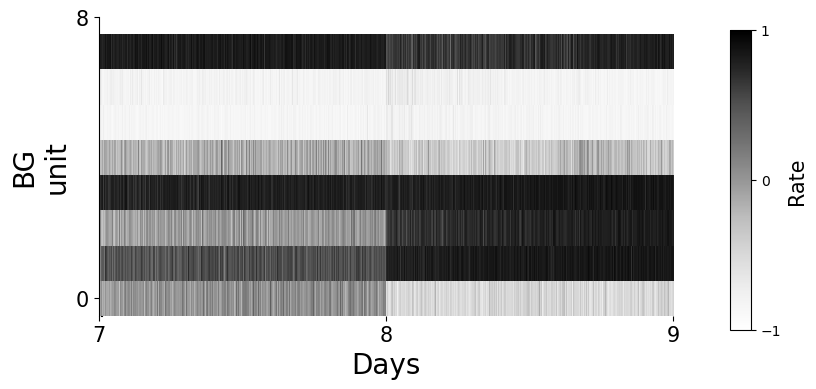

In [33]:
def plot_BG_single(obj, first_day, last_day):
    figure, (ax2) = plt.subplots(1,1, figsize=(7, 4))   

    cm = plt.cm.get_cmap('Greys')
    plot_array1 = obj.hvc_bg_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    # im1 = ax1.imshow(plot_array1[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')
    plot_array2 = obj.bg_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    spike_raster = bin_and_plot_spikes(sigmoid(plot_array2[:, 0, :], m=4, a=0), factor = 60, bin_size=100).T
    # im2 = ax2.imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')
    im2 = ax2.imshow(plot_array2[first_day*TRIALS: last_day*TRIALS,0,:10].T, cmap=cm, aspect='auto', interpolation='none', vmin = -1, vmax = 1)

    # figure.subplots_adjust(right=1.2)
    # cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35])
    # cbar = figure.colorbar(im1, cax=cbar_ax)
    # cbar.set_label('Synaptic strength', fontsize=15)
    # cbar.set_ticks([-1, 0, 1])
    

    # ax1.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)   
    # ax2.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)
    # ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    # ax1.spines['top'].set_visible(False)
    # ax1.spines['right'].set_visible(False)
    # ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20))     
    # ax1.tick_params(labelsize=15)
    # ax1.set_yticks([0, 8])
    # ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    # ax1.set_ylim(-0.5, 7.5)
    # ax1.set_xlabel('Days', fontsize=20)
    # ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    # ax1.set_ylabel('HVC-BG\nweights', fontsize=20)

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.75])
    cbar = figure.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Rate', fontsize=15)
    cbar.set_ticks([-1,0, 1])

    ax2.set_ylim(-0.5, 7)
    # ax2.set_xlim(- TRIALS + first_day*TRIALS, 5 + (last_day)*TRIALS)        
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 8])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks(np.arange(0*TRIALS, (last_day-first_day+1)*TRIALS, 1*TRIALS), np.arange(first_day, last_day+1))
    # ax2.set_xlim(7*N_DAILY_MOTIFS, 9*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(first_day, last_day+1)       

    ax2.set_ylabel('BG\nunit', fontsize=20)
    plt.tight_layout()
    plt.show()

plot_BG_single(obj, 7, 9)

/tmp/ipykernel_149845/3602472354.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Greys')
/tmp/ipykernel_149845/3602472354.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


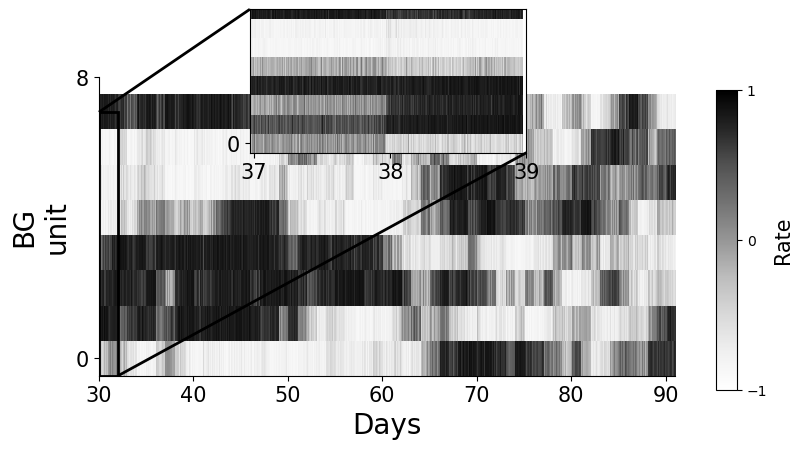

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def plot_BG_single(obj, first_day, last_day):
    figure, ax2 = plt.subplots(1, 1, figsize=(7, 4))   

    cm = plt.cm.get_cmap('Greys')
    plot_array2 = obj.bg_all.reshape(DAYS * N_DAILY_MOTIFS, N_SYLL, 8)
    
    full_data = plot_array2[:, 0, :10].T
    im2 = ax2.imshow(full_data, cmap=cm, aspect='auto', interpolation='none', vmin=-1, vmax=1)

    # === Zoom Inset (Placed Outside) === #
    zoom_ax = inset_axes(ax2,
                         width="40%", height="60%",
                         bbox_to_anchor=(0.25, 0.45, 1.2, 0.8),
                         bbox_transform=ax2.transAxes,
                         loc='upper left')
    
    zoom_data = plot_array2[first_day*TRIALS : last_day*TRIALS, 0, :10].T
    zoom_im = zoom_ax.imshow(zoom_data, cmap=cm, aspect='auto', interpolation='none', vmin=-1, vmax=1)

    # Set zoom x-ticks and y-ticks
    zoom_ax.set_xticks(np.arange(0, (last_day - first_day + 1) * TRIALS, TRIALS)+30)
    zoom_ax.set_xticklabels(np.arange(first_day, last_day + 1)+30)
    zoom_ax.set_yticks([0, 8])
    zoom_ax.tick_params(labelsize=15)
    zoom_ax.set_ylim(-0.5, 7)

    # Remove connecting lines since it's outside (or you can use annotate if you like)
    mark_inset(ax2, zoom_ax, loc1=2, loc2=4, fc="none", ec="black", lw=2)

    # Main axis settings
    ax2.set_ylim(-0.5, 7)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 8])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks(np.arange(0 * TRIALS, DAYS * TRIALS, 10 * TRIALS),
                   np.arange(0, DAYS, 10)+30)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylabel('BG\nunit', fontsize=20)

    # Colorbar
    figure.subplots_adjust(right=0.85)  # Leave space for zoom inset
    cbar_ax = figure.add_axes([1.03, 0.16, 0.03, 0.75])
    cbar = figure.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Rate', fontsize=15)
    cbar.set_ticks([-1, 0, 1])

    plt.tight_layout()
    plt.show()

# Usage
plot_BG_single(obj, 7, 9)


/tmp/ipykernel_149845/3019811680.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('bwr', num_groups)


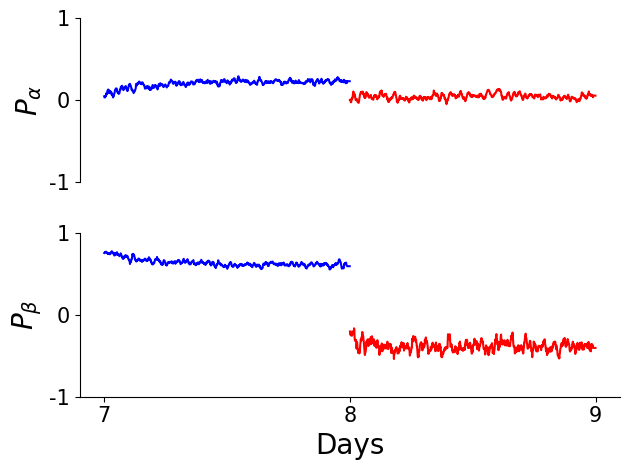

In [35]:
def plot_output_specific(obj, first_day, last_day, syll = 0): 
    figure, (ax1, ax2) = plt.subplots(2,1)
    
    sk = N_SYLL
    LIMIT = 1.5

    # Display x axis in days
    x = np.arange(N_TOTAL_TRIALS)
    x = x/(N_DAILY_MOTIFS * N_SYLL)

    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    # Data
    group_size = 1  # days
    num_groups = (last_day - first_day) // group_size
    colors = cm.get_cmap('bwr', num_groups)

    # for syll in range(N_SYLL):
    traj_x = obj.actions[:, :, syll, 0].reshape(DAYS * N_DAILY_MOTIFS)
    traj_y = obj.actions[:, :, syll, 1].reshape(DAYS * N_DAILY_MOTIFS)

    for g in range(num_groups):
        start_day = g * group_size + first_day  
        end_day = (g + 1) * group_size + first_day
        start_idx = start_day * N_DAILY_MOTIFS
        end_idx = end_day * N_DAILY_MOTIFS

        # Time axis shifted to correct starting day
        time_segment = np.arange(end_idx - start_idx) + start_idx
        time_segment_days = time_segment 

        ax1.plot(
            time_segment_days,
            running_mean(traj_x[start_idx:end_idx], 10),
            color=colors(g),
            lw=1.5
        )
        ax2.plot(
            time_segment_days,
            running_mean(traj_y[start_idx:end_idx], 10),
            color=colors(g),
            lw=1.5
        )
    
    # for syll in range(N_SYLL - 1):
    #     syll = 0
    #     # target
    #     ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1, label = 'Target')
    #     ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1)
    # if N_SYLL > 1:
    #     ax1.plot(obj.centers[syll + 1, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1)
    #     ax2.plot(obj.centers[syll + 1, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='black', linestyle='--', linewidth=1, label = 'Target')
    # # elif N_SYLL == 1:
    # ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*(last_day - last_day)),  color='black', linestyle='--', linewidth=1, label = 'Target')
    # ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*(last_day - first_day)),  color='black', linestyle='--', linewidth=1)
        
    # # Axis beauty
    # ax1.axvline(x=BG_INTACT_DAYS * TRIALS, linestyle=':', color='grey', lw=1, label='Lesion')
    # ax2.axvline(x=BG_INTACT_DAYS * TRIALS, linestyle=':', color='grey', lw=1)
    # ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
    # ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylim(-LIMIT, LIMIT)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1])
    # ax1.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1])  
    ax2.set_ylim(-LIMIT, LIMIT)
    ax2.tick_params(labelsize=15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    # ax2.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    # ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)
    
    ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
    ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    # Remove duplicate legend entries
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.0, 1.1))

    # plt.legend()
    plt.xticks(np.arange(first_day*TRIALS, (last_day+1)*TRIALS, 1*TRIALS), np.arange(first_day, last_day+1))
    plt.tight_layout()
    plt.show()

plot_output_specific(obj, 7, 9) 

/tmp/ipykernel_149845/328668034.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


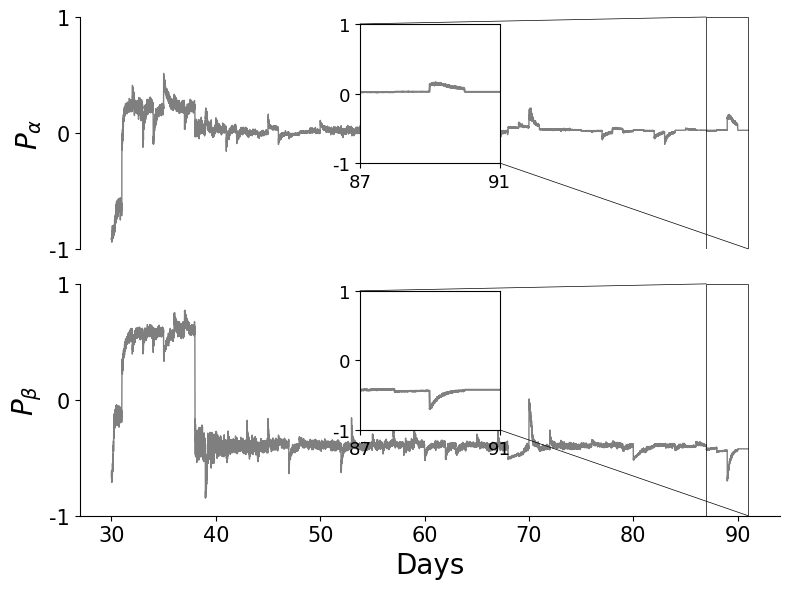

In [36]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def plot_output_with_zoom(obj, zoom_start_day, zoom_end_day, total_days=61, syll=0):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    LIMIT = 1.5
    zoom_start_idx = zoom_start_day * N_DAILY_MOTIFS
    zoom_end_idx = zoom_end_day * N_DAILY_MOTIFS
    total_trials = total_days * N_DAILY_MOTIFS

    traj_x = obj.actions[:, :, syll, 0].reshape(DAYS * N_DAILY_MOTIFS)
    traj_y = obj.actions[:, :, syll, 1].reshape(DAYS * N_DAILY_MOTIFS)

    # Time axis in days
    time_axis = np.arange(DAYS * N_DAILY_MOTIFS) / (N_DAILY_MOTIFS)

    # Plot full trajectory
    ax1.plot(time_axis[:total_trials], running_mean(traj_x[:total_trials], 10), color='black', lw=1, alpha =0.5) 
    ax2.plot(time_axis[:total_trials], running_mean(traj_y[:total_trials], 10), color='black', lw=1, alpha =0.5)

    # === Zoom inset === #
    zoom_ax1 = inset_axes(ax1, width="20%", height="60%", loc='upper center')
    zoom_ax2 = inset_axes(ax2, width="20%", height="60%", loc='upper center')

    zoom_time = time_axis[zoom_start_idx:zoom_end_idx]
    zoom_traj_x = running_mean(traj_x[zoom_start_idx:zoom_end_idx], 10)
    zoom_traj_y = running_mean(traj_y[zoom_start_idx:zoom_end_idx], 10)

    zoom_ax1.plot(zoom_time, zoom_traj_x, color='grey', lw=1.5)
    zoom_ax2.plot(zoom_time, zoom_traj_y, color='grey', lw=1.5)

    # Zoom aesthetics
    for z_ax in [zoom_ax1, zoom_ax2]:
        z_ax.set_xlim(zoom_start_day, zoom_end_day)
        z_ax.set_ylim(-LIMIT, LIMIT)
        z_ax.tick_params(labelsize=13)
        z_ax.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1])
        z_ax.set_xticks([zoom_start_day, zoom_end_day], [zoom_start_day+30, zoom_end_day+30]) 


    # Highlight zoomed region with thick connecting lines
    mark_inset(ax1, zoom_ax1, loc1=2, loc2=4, fc="none", ec="black", lw=0.5)
    mark_inset(ax2, zoom_ax2, loc1=2, loc2=4, fc="none", ec="black", lw=0.5)

    ax1.set_ylim(-LIMIT, LIMIT)
    ax2.set_ylim(-LIMIT, LIMIT)
    ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
    ax2.set_xlabel('Days', fontsize=20)
    ax1.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1])  
    ax2.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1])  
    ax1.set_xticks([])
    ax2.set_xticks(np.arange(0 , DAYS + 1, 10), np.arange(0, DAYS + 1, 10) +30)

    ax1.tick_params(labelsize=15)
    ax2.tick_params(labelsize=15)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


# Usage
plot_output_with_zoom(obj, zoom_start_day=57, zoom_end_day=61, total_days=61)


/tmp/ipykernel_149845/1516661215.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('bwr', num_groups)


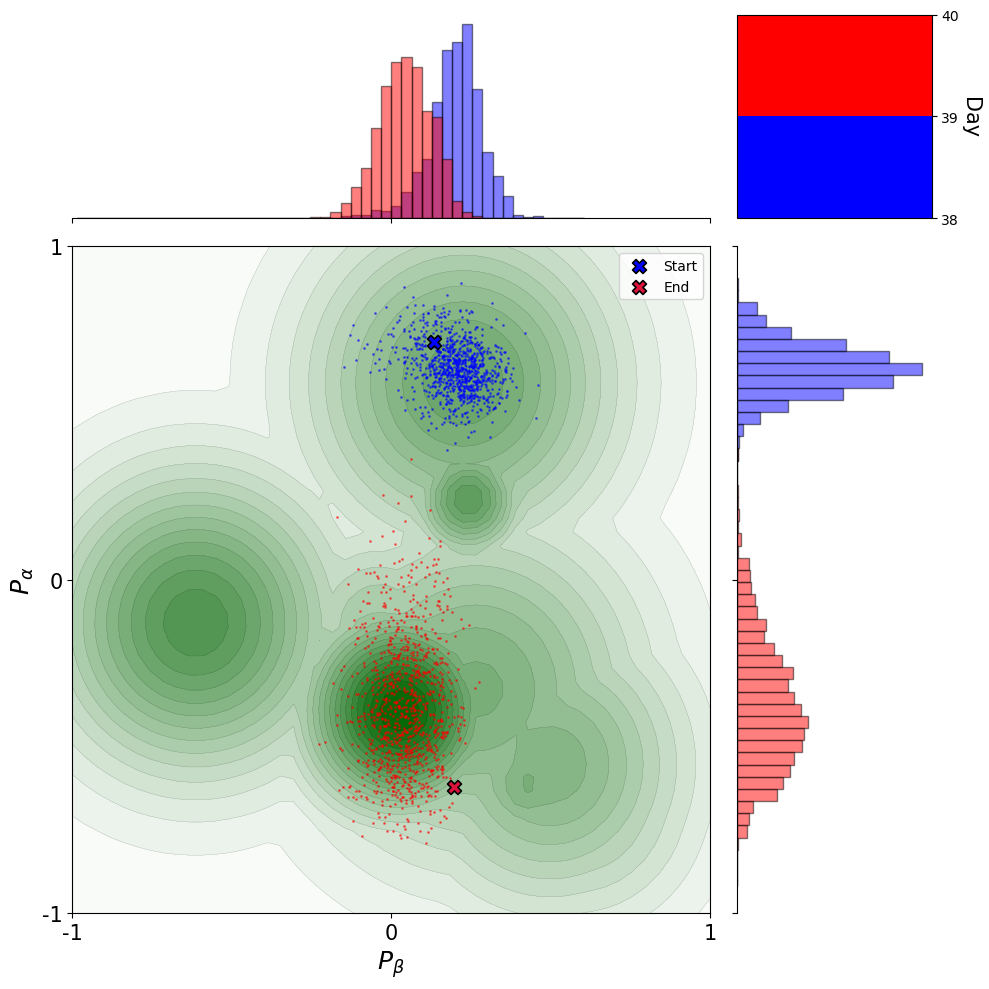

In [37]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_traj_spec_days(syll, first_day, last_day, group_size=1):
    x_traj, y_traj = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    x_traj = np.array(x_traj)
    y_traj = np.array(y_traj)

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig)

    # Axes layout
    ax_main = fig.add_subplot(gs[1:, 0:3])    # Main trajectory plot
    ax_xhist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)  # X histogram
    ax_yhist = fig.add_subplot(gs[1:, 3], sharey=ax_main)   # Y histogram
    ax_cbar = fig.add_subplot(gs[0, 3])  # Colorbar axis

    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'darkgreen'])

    if obj.LANDSCAPE == 0:
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = ax_main.contourf(X, Y, Z, levels=20, cmap=cmap)
        ax_main.contour(X, Y, Z, levels=20, colors='k', linewidths=0.2, alpha=0.3)

    else:
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
        ax_main.contour(X, Y, Z, levels=20, colors='k', linewidths=0.2, alpha=0.3)

        ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    # Plot key trajectory points with clearer colors and better labels
    ax_main.scatter(
        x_traj[first_day*TRIALS], y_traj[first_day*TRIALS], 
        s=100, c='blue', marker='X',
        label='Start',
        edgecolor='black', linewidth=1.2, zorder=3
    )

    # ax_main.scatter(
    #     x_traj[BG_INTACT_DAYS*TRIALS-1], y_traj[BG_INTACT_DAYS*TRIALS-1],
    #     s=100, c='orange', marker='X',
    #     label='End Before Lesion',
    #     edgecolor='black', linewidth=1.2, zorder=4
    # )

    ax_main.scatter(
        x_traj[last_day*TRIALS], y_traj[last_day*TRIALS],   
        s=100, c='crimson', marker='X',
        label='End',
        edgecolor='black', linewidth=1.2, zorder=5
    )

    ax_main.set_ylabel(r'$P_{\alpha}$', fontsize=18)
    ax_main.set_xlabel(r'$P_{\beta}$', fontsize=18)
    ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
    ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)

    # Histograms
    # group_size = 1

    num_groups = (last_day- first_day) // group_size
    # colors = LinearSegmentedColormap.from_list('blue_to_red', ['blue', 'red'], N=num_groups)
    colors = cm.get_cmap('bwr', num_groups)

    num_bins = 50
    x_bin_edges = np.linspace(x_traj.min(), x_traj.max(), num_bins + 1)
    y_bin_edges = np.linspace(y_traj.min(), y_traj.max(), num_bins + 1)

    for group in range(num_groups):
        start_day = group * group_size + first_day
        end_day = (group + 1) * group_size + first_day
        start_idx = start_day * TRIALS
        end_idx = end_day * TRIALS

        ax_xhist.hist(
            x_traj[start_idx:end_idx],
            bins=x_bin_edges,
            alpha=0.5,
            color=colors(group),
            edgecolor='black'
        )

        ax_yhist.hist(
            y_traj[start_idx:end_idx],
            bins=y_bin_edges,
            orientation='horizontal',
            alpha=0.5,
            color=colors(group),
            edgecolor='black'
        )

        ax_main.scatter(
            x_traj[start_idx:end_idx:1],
            y_traj[start_idx:end_idx:1],
            color=colors(group),
            s=1,
            alpha=0.5
        )
    ax_main.legend()

    # Styling histograms
    ax_xhist.set_yticks([])
    ax_xhist.spines['top'].set_visible(False)
    ax_xhist.spines['right'].set_visible(False)
    ax_xhist.spines['left'].set_visible(False)

    ax_yhist.set_xticks([])
    ax_yhist.spines['top'].set_visible(False)
    ax_yhist.spines['right'].set_visible(False)
    ax_yhist.spines['bottom'].set_visible(False)

    plt.setp(ax_xhist.get_xticklabels(), visible=False)
    plt.setp(ax_yhist.get_yticklabels(), visible=False)
    # ax_xhist.set_ylabel("Freq (X)")
    # ax_yhist.set_xlabel("Freq (Y)")

    # Add colorbar for groups
    norm = Normalize(vmin=0, vmax=num_groups * group_size)
    sm = ScalarMappable(cmap=colors, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, cax=ax_cbar, orientation='vertical')
    cbar.set_label('Day', rotation=270, labelpad=15, fontsize=15)   
    cbar.set_ticks([group_size * i for i in range(num_groups + 1)])
    cbar.set_ticklabels([f"{group_size * i + first_day + 31}" for i in range(num_groups + 1)])

    plt.tight_layout()
    plt.show()

plot_traj_spec_days(0,7,9)

/tmp/ipykernel_149845/2512586061.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=12)


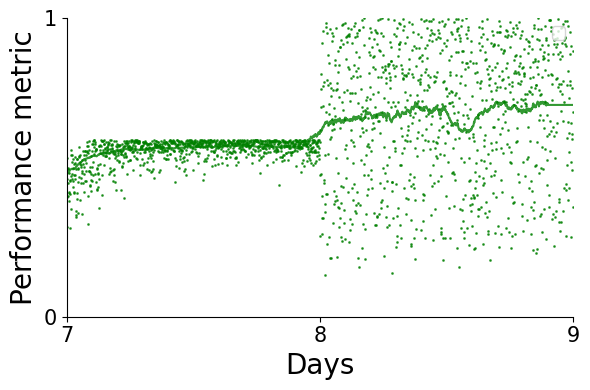

In [38]:
def plot_reward_specific(obj, first_day, last_day, syll=0):
    figure, ax = plt.subplots(1, figsize=(6, 4))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    cmap = plt.get_cmap('tab10')
    syllable_colors = [cmap(i) for i in range(N_SYLL)]

    array = obj.rewards[:, :, syll].reshape(DAYS * N_DAILY_MOTIFS)
    start = first_day * N_DAILY_MOTIFS
    end = last_day * N_DAILY_MOTIFS
    segment = array[start:end]

    # Plot raw reward (dots)
    ax.plot(np.arange(start, end, 1), segment[::1], marker='.', linestyle='None', alpha=0.7, markersize=2, color='green')

    # Plot running mean (line)
    window = 100
    smooth = running_mean(segment, window)
    smooth_x = np.arange(start, end)
    ax.plot(smooth_x, smooth, lw=1.5, alpha=0.8, color='green')

    ax.set_xlabel('Days', fontsize=20)
    ax.set_ylabel('Performance metric', fontsize=20)
    ax.set_ylim(0, 1)
    ax.tick_params(labelsize=15)
    ax.set_yticks([0, 1])

    ax.set_xlim(start, end)
    ax.set_xticks(
        np.arange(start, end + 1, 1 * N_DAILY_MOTIFS),
        np.arange(first_day, last_day + 1, 1)
    )

    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()



plot_reward_specific(obj, 7, 9)

/tmp/ipykernel_149845/401755297.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


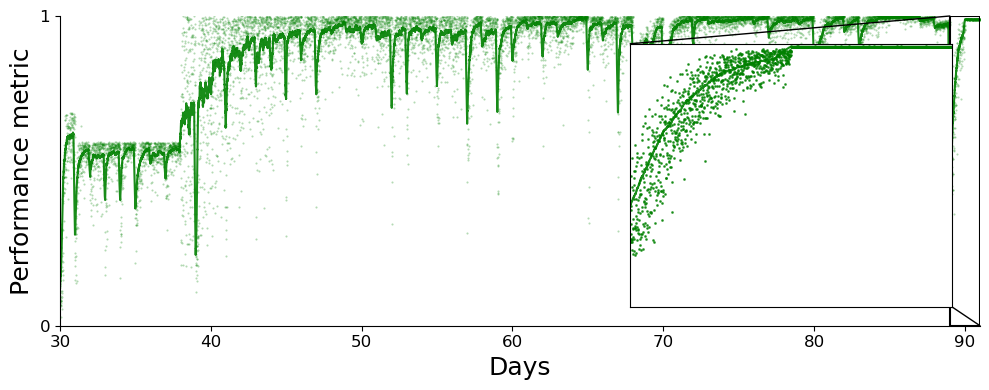

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_reward_with_zoom(obj, main_first_day=0, main_last_day=60, zoom_first_day=7, zoom_last_day=9, syll=0):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    array = obj.rewards[:, :, syll].reshape(DAYS * N_DAILY_MOTIFS)

    # Main plot segment
    start_main = main_first_day * N_DAILY_MOTIFS
    end_main = main_last_day * N_DAILY_MOTIFS
    segment_main = array[start_main:end_main]
    every_nth = 5

    # Plot raw reward (main)
    ax.plot(np.arange(start_main, end_main, every_nth), segment_main[::every_nth], marker='.', linestyle='None', alpha=0.3, markersize=1, color='green')

    # Plot running mean (main)
    smooth_main = running_mean(segment_main, 100)
    smooth_x_main = np.arange(start_main, end_main)
    ax.plot(smooth_x_main, smooth_main, lw=1.5, alpha=0.9, color='green')

    ax.set_xlabel('Days', fontsize=18)
    ax.set_ylabel('Performance metric', fontsize=18)
    ax.set_ylim(0, 1)
    ax.tick_params(labelsize=12)
    ax.set_yticks([0, 1])
    ax.set_xticks(np.arange(start_main, end_main + 1, 10 * N_DAILY_MOTIFS), 30 + np.arange(main_first_day, main_last_day + 1, 10))
    ax.set_xlim(start_main, end_main)


    # === Zoomed Inset === #
    axins = inset_axes(ax, width="35%", height="85%", loc='upper right', borderpad=2)

    start_zoom = zoom_first_day * N_DAILY_MOTIFS
    end_zoom = zoom_last_day * N_DAILY_MOTIFS
    segment_zoom = array[start_zoom:end_zoom]

    axins.plot(np.arange(start_zoom, end_zoom), segment_zoom, marker='.', linestyle='None', alpha=0.7, markersize=2, color='green')
    smooth_zoom = running_mean(segment_zoom, 100)
    smooth_x_zoom = np.arange(start_zoom, end_zoom)
    axins.plot(smooth_x_zoom, smooth_zoom, lw=1.5, alpha=0.9, color='green')

    axins.set_xlim(start_zoom, end_zoom)
    axins.set_ylim(0, 1)
    axins.set_xticks([])
    axins.set_yticks([])

    ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1, lw=1.5) 

    plt.tight_layout()
    plt.show()

plot_reward_with_zoom(obj, 0, 61, 59, 61)

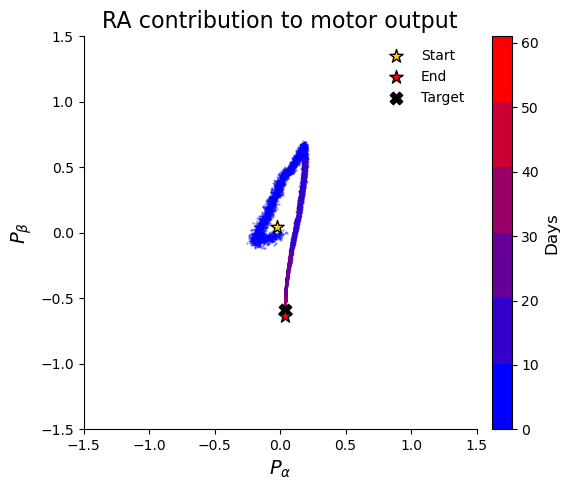

In [40]:
def plot_RA_traj(syll, group_size=10):
    # Compute RA contribution
    ra_actions = obj.actions - obj.actions_bg
    x_traj, y_traj = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_traj = np.array(x_traj)
    y_traj = np.array(y_traj)

    fig, ax = plt.subplots(figsize=(8, 5))

    num_groups = DAYS // group_size
    cmap = LinearSegmentedColormap.from_list('blue_to_red', ['blue', 'red'], N=num_groups)
    norm = Normalize(vmin=0, vmax=DAYS)

    for g in range(num_groups):
        start_day = g * group_size
        end_day = (g + 1) * group_size
        start_idx = start_day * N_DAILY_MOTIFS
        end_idx = end_day * N_DAILY_MOTIFS

        ax.plot(
            x_traj[start_idx:end_idx:2],
            y_traj[start_idx:end_idx:2],
            lw=0,
            color=cmap(g),
            marker='.',
            markersize=1,
            alpha=0.5
        )

    # Mark start and end
    ax.scatter(x_traj[0], y_traj[0], s=100, c='gold', edgecolor='black', marker='*', label='Start', zorder=5)
    ax.scatter(x_traj[-1], y_traj[-1], s=100, c='red', edgecolor='black', marker='*', label='End', zorder=5)

    # Target
    ax.scatter(obj.centers[syll, 0], obj.centers[syll, 1], c='black', s=80, marker='X', label='Target', zorder=4)

    # Plot formatting
    ax.set_title(f"RA contribution to motor output", fontsize=16)
    ax.set_xlabel(r'$P_{\alpha}$', fontsize=14)
    ax.set_ylabel(r'$P_{\beta}$', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-obj.limit, obj.limit)
    ax.set_ylim(-obj.limit, obj.limit)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), frameon=False, fontsize=10)

    # Add color bar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Days', fontsize=12)
    cbar.set_ticks([i * group_size for i in range(num_groups + 1)])
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

# Example usage
plot_RA_traj(0)


In [41]:
def spike_plotter(rate_array, time_points_per_rate, factor=1):
    """
    Converts a coarse rate array into a fine-grained Poisson spike raster.

    Args:
        rate_array: np.array of shape (time_bins, channels)
        time_points_per_rate: int, number of fine time steps per coarse time bin
        factor: float, scaling factor for rate values

    Returns:
        spike_raster: np.array of shape (time_bins * time_points_per_rate, channels)
    """
    time_bins, channels = rate_array.shape
    fine_time = time_bins * time_points_per_rate
    spike_raster = np.zeros((fine_time, channels), dtype=int)

    for c in range(channels):
        for t in range(time_bins):
            start = t * time_points_per_rate
            end = (t + 1) * time_points_per_rate

            mean_rate = rate_array[t, c]  # rate for this bin

            # Calculate per-step Poisson probability
            rate_per_step = factor * mean_rate / time_points_per_rate

            # Generate Bernoulli trials across the bin
            spikes = np.random.rand(time_points_per_rate) < rate_per_step

            # Fill spike raster
            spike_raster[start:end, c] = spikes.astype(int)

    return spike_raster


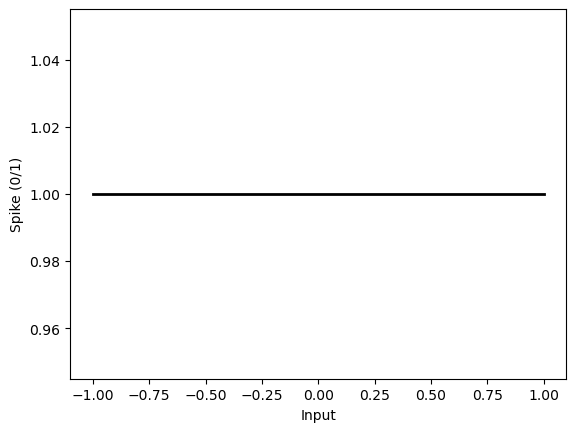

In [42]:
rate_inputs = np.linspace(-1, 1, 100)
rate_inputs = np.expand_dims(rate_inputs, axis=1)

rate_inputs_sigmoid = sigmoid(rate_inputs, m=3, a=0)

spikes = bin_and_plot_spikes(rate_inputs_sigmoid, bin_size=1, factor=50)

plt.plot(rate_inputs[:,0], spikes[:,0], color='black', lw=2)
plt.xlabel('Input')
plt.ylabel('Spike (0/1)')
plt.show()



In [43]:
obj.ra_all.shape

(61, 1000, 4, 8)

/tmp/ipykernel_149845/2040601975.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


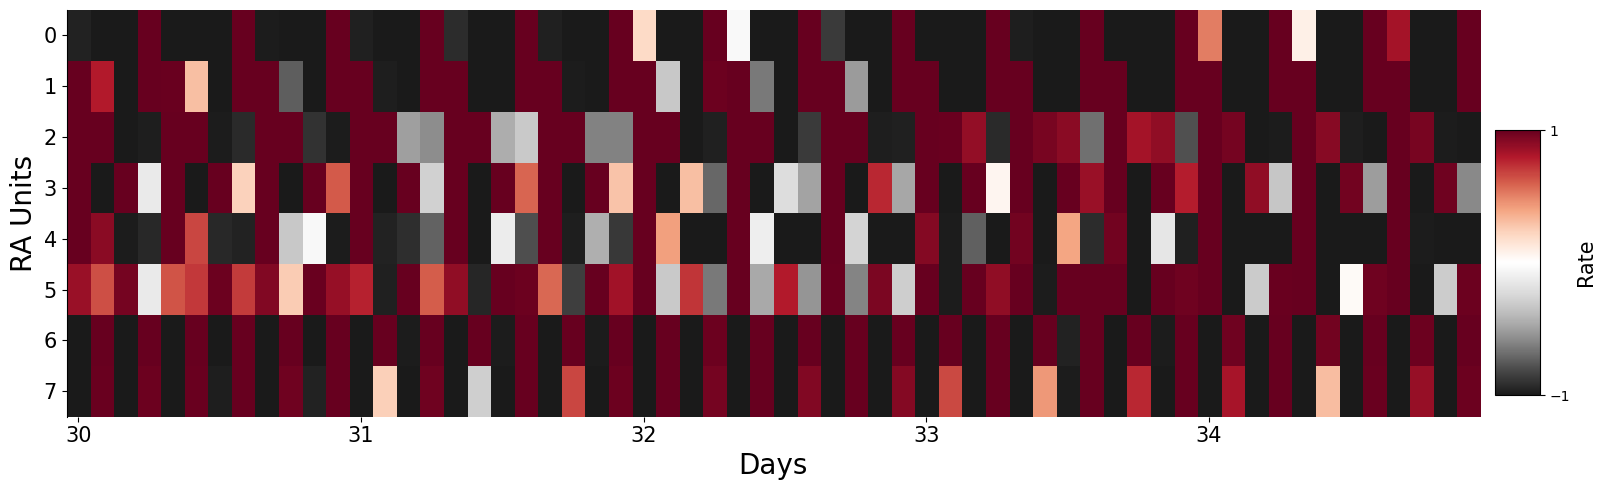

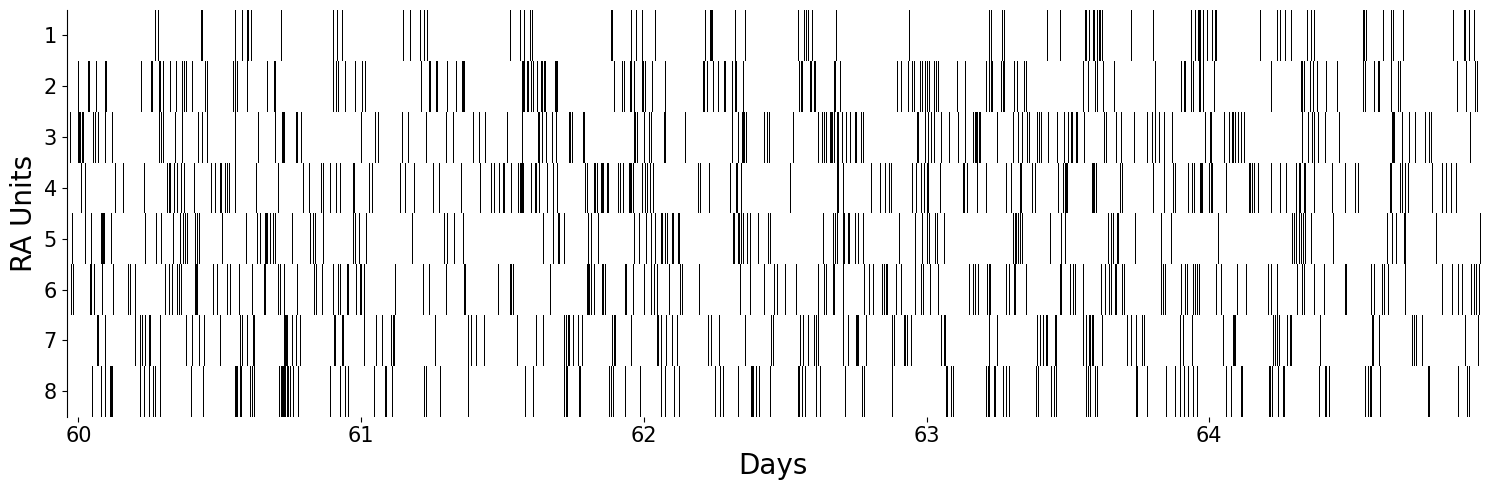

/tmp/ipykernel_149845/2040601975.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


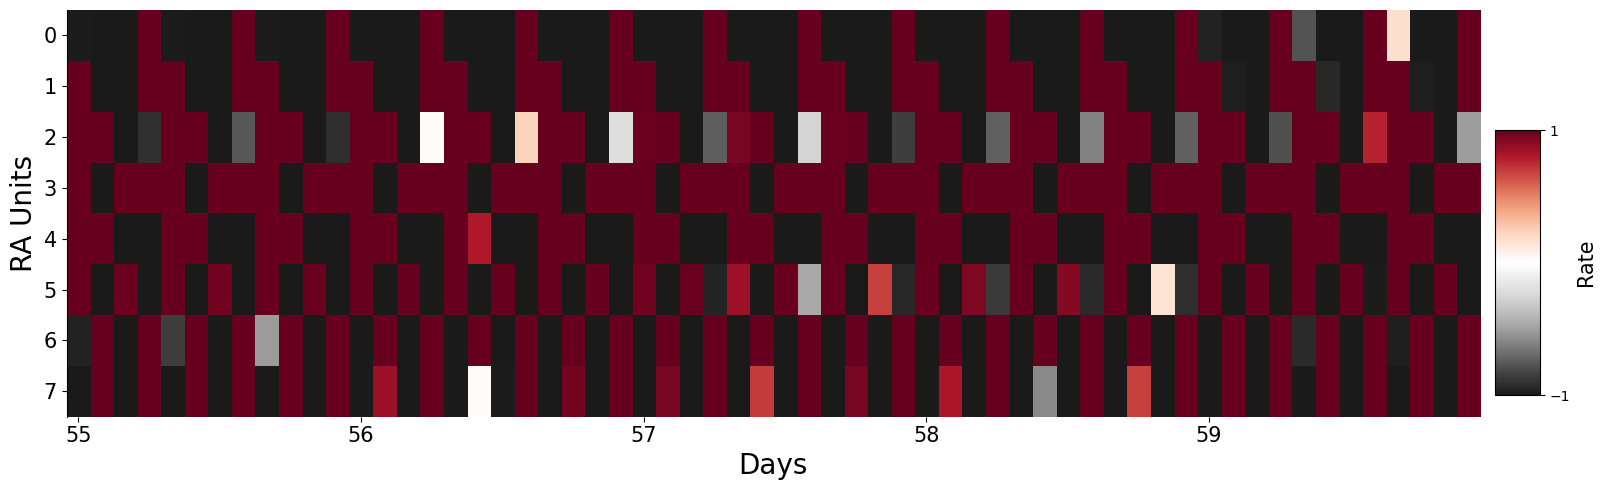

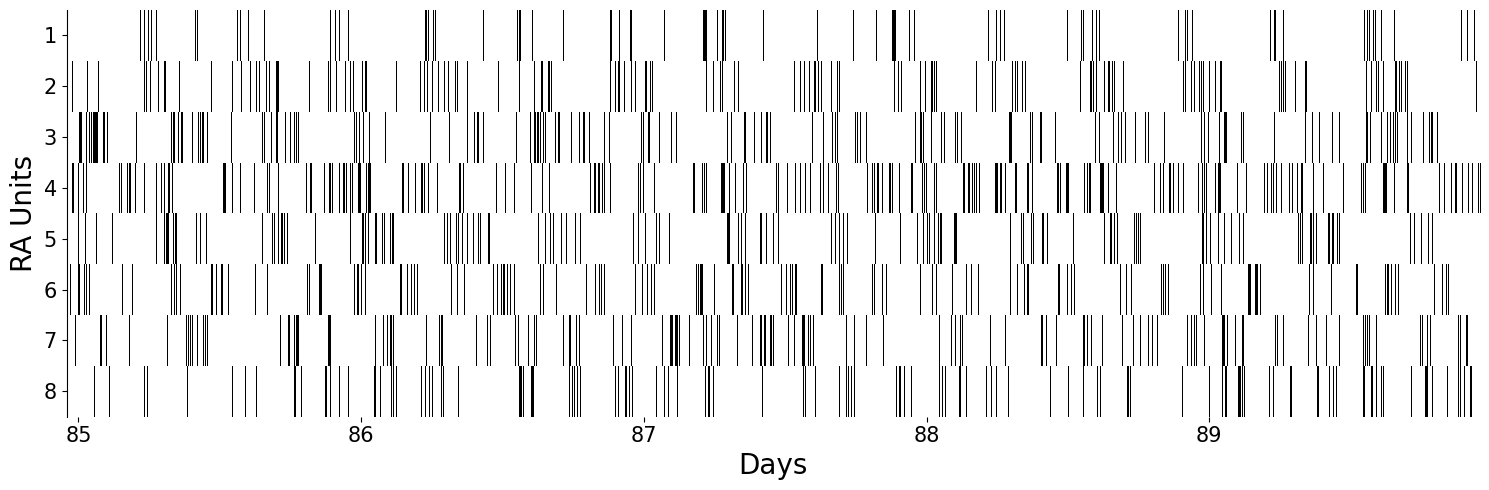

In [44]:
def plot_HL_motifs_days_rate(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(15,5))

    # cm = plt.cm.get_cmap('RdGy_r')
    nos_trials_per_day = 3
    plot_array = obj.ra_all[day:day+5, :nos_trials_per_day, :, :].reshape(5*nos_trials_per_day*N_SYLL, 8)
    # plt.hist(plot_array.flatten(), bins=100, color='black', alpha=0.5)  
    # plt.show()
    # plot_array = np.tanh(plot_array)
    # plot_array = sigmoid(plot_array, m=1, a=0)
    # spike_raster = bin_and_plot_spikes(sigmoid(plot_array, m=1, a=0), factor=1, bin_size= 6)
    # spike_raster = plot_array
    im1 = ax1.imshow(plot_array.T, aspect='auto', cmap='RdGy_r', interpolation='nearest', vmin = -1, vmax = 1)   
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.00, 0.2, 0.03, 0.53])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Rate', fontsize=15)
    cbar.set_ticks([-1, 1])
    # ax1.set_xlim(0, 10*N_SYLL)
    ax1.set_xticks(np.arange(0, N_SYLL*nos_trials_per_day*5, N_SYLL*nos_trials_per_day), day + np.arange(0, 5,1), fontsize=15)
    # ax1.set_xlim(0, 10*N_SYLL)
    # ax1.set_xticks()
    # ax1.set_xticks(np.arange(0, N_SYLL*10, N_SYLL), np.arange(0, 10), fontsize=15)
    ax1.tick_params(labelsize=15)
    # ax1.set_xticks(range(N_SYLL), [i for i in alphabets[:N_SYLL]])
    ax1.set_ylabel('RA Units', fontsize=20)    
    ax1.set_xlabel('Days', fontsize=20)
    # ax1.set_title(f'Days {day+30} to {day + 35}', fontsize=20)
    # ax1.set_xlim(0, TRIALS*N_SYLL)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_HL_motifs_on_day_spike(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(15,5))
    spike_bins = 100    
    nos_trials_per_day = 3
    plot_array = obj.ra_all[day:day+5, :nos_trials_per_day, :, :].reshape(5*nos_trials_per_day*N_SYLL, 8)
    spike_raster = spike_plotter(sigmoid(plot_array, m=3, a=0), time_points_per_rate=spike_bins, factor=20)
    im1 = ax1.imshow(spike_raster.T, aspect='auto', cmap='Greys', interpolation='nearest', vmin=0, vmax=1)
    figure.subplots_adjust(right=1.2)
    # cbar_ax = figure.add_axes([1.00, 0.2, 0.03, 0.53])
    # cbar = figure.colorbar(im1, cax=cbar_ax)
    # cbar.set_label('Rate', fontsize=15)
    # cbar.set_ticks([0, 1])
    ax1.set_yticks(np.arange(8),np.arange(1, 9,1), fontsize=15)     
    ax1.set_xticks(np.arange(50, N_SYLL*nos_trials_per_day*5*spike_bins, N_SYLL*nos_trials_per_day*spike_bins), day +30 + np.arange(0, 5,1), fontsize=15)
    ax1.tick_params(labelsize=15)
    ax1.set_ylabel('RA Units', fontsize=20)    
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()


plot_HL_motifs_days_rate(obj,30)
plot_HL_motifs_on_day_spike(obj,30)
plot_HL_motifs_days_rate(obj, 55) 
plot_HL_motifs_on_day_spike(obj,55)

/tmp/ipykernel_149845/1313521653.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


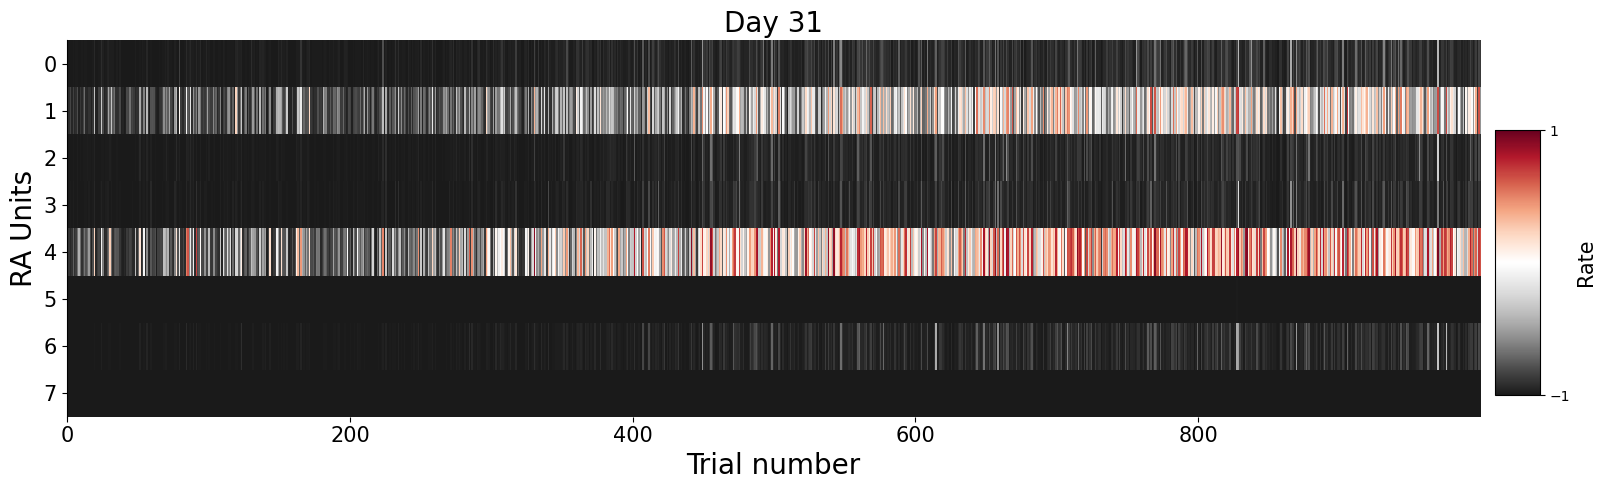

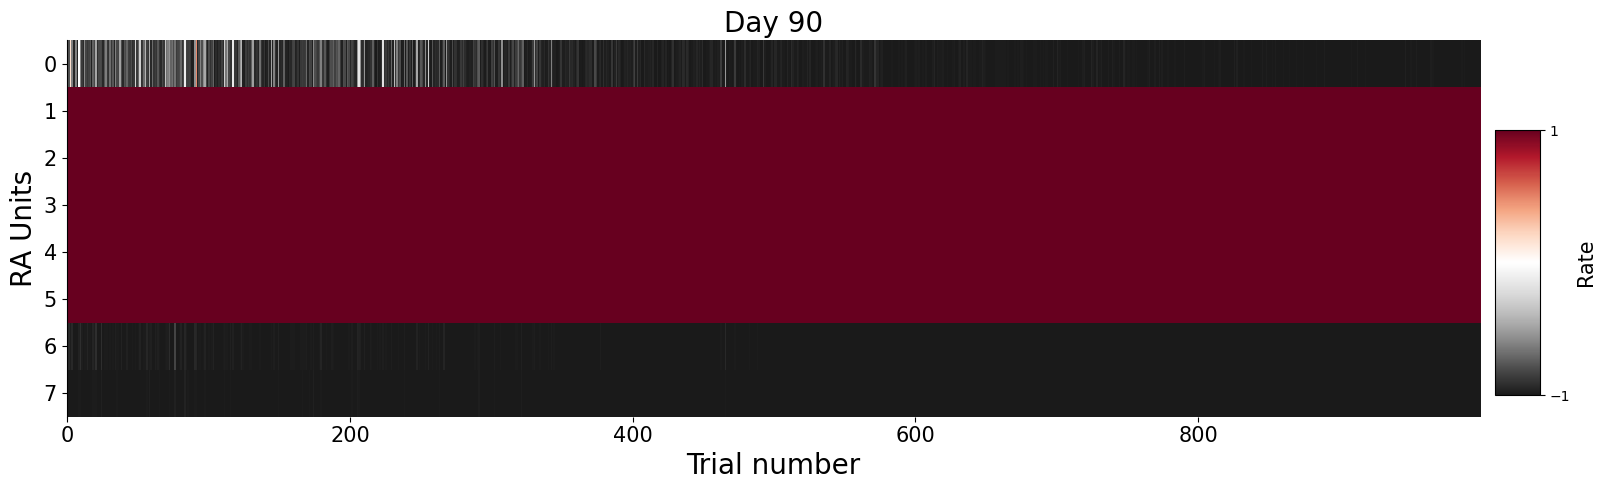

In [45]:
def plot_HL_syll_on_day_rate(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(15,5))
    nos = 1000
    plot_array = obj.ra_all[day, :nos, 0, :].reshape(nos*1, 8)
    im1 = ax1.imshow(plot_array.T, aspect='auto', cmap='RdGy_r', interpolation='nearest', vmin = -1, vmax = 1)
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.00, 0.2, 0.03, 0.53])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Rate', fontsize=15)
    cbar.set_ticks([-1, 1])
    ax1.tick_params(labelsize=15)
    ax1.set_ylabel('RA Units', fontsize=20)    
    ax1.set_xlabel('Trial number', fontsize=20)
    ax1.set_title(f'Day {day+31}', fontsize=20) 
    # ax1.set_xlim(0, TRIALS*N_SYLL)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_HL_syll_on_day_rate(obj, 0)
plot_HL_syll_on_day_rate(obj, 59)

In [46]:
# def plot_HL_motifs_on_day(obj, day):
#     """ Plots the model output over time. """
#     alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
#     figure, (ax1) = plt.subplots(1, figsize=(6,5))

#     cm = plt.cm.get_cmap('RdGy_r')
#     plot_array = obj.bg_all[day, :, :, 1].reshape(N_DAILY_MOTIFS, N_SYLL)
#     im = ax1.imshow(plot_array, cmap=cm, aspect='auto', interpolation='none')

#     figure.subplots_adjust(right=1.2)
#     cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
#     cbar = figure.colorbar(im, cax=cbar_ax)
#     cbar.set_label('Firing rate', fontsize=15)
#     cbar.set_ticks([-1, 0, 1])

#     ax1.set_ylim(0, 1000)
#     ax1.set_yticks([1000, 0])
#     ax1.tick_params(labelsize=15)
#     ax1.set_xticks(range(N_SYLL), [i for i in alphabets[:N_SYLL]])
#     ax1.set_xlabel('Syllables', fontsize=20)    
#     ax1.set_ylabel('Motif number', fontsize=20)
#     ax1.set_title(f'Day {day}', fontsize=20)

#     ax1.spines['top'].set_visible(False)
#     ax1.spines['right'].set_visible(False)  
#     ax1.spines['bottom'].set_visible(False)
#     plt.tight_layout()


In [47]:
# plot_trajectory(0) 
# plot_trajectory(1)
# # plot_dw_day(0)
# plot_output
        
# ra_all = obj.generate_results(i)
# obj.plot_results(i)


# def build_and_run(seed, annealing, plot):
#     tqdm.write(f" Random seed is {seed}")
#     np.random.seed(seed)
#     obj = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
#     obj.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)
#     remove_prev_files()
#     for i in range(N_SYLL):
#         obj.save_trajectory(i)
#         obj.save_results(i)
#         if ANNEALING:
#             obj.save_dw_day(i)
#     return np.mean(obj.rewards[:,-100:], axis=1)